# Projet de statistiques des risques extrêmes

- Binome 1 : Mathis BOUILLON
- Binome 2 : Cheryl KOUADIO

## Installation des packages
---

In [ ]:
from arch import arch_model
from scipy.stats import jarque_bera
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from statsmodels.stats.diagnostic import acorr_ljungbox
import yfinance as yf
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import chi2, genextreme as gev,genpareto
import plotly.graph_objects as go
import seaborn as sns
import scipy.integrate as spi
import scipy.optimize as spo
from scipy.stats import t
from scipy.optimize import minimize
from scipy.stats import norm
import scipy.stats as stats
# from scipy.stats import genpareto
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch

/Users/cherylkouadio/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Importation des données
---

In [2]:
def telecharger_donnees(ticker, start_date="1900-01-01"):
    """
    Télécharge les données boursières pour un ticker donné depuis Yahoo Finance.

    Paramètres :
    - ticker (str) : Le symbole boursier (ex: "^FCHI" pour le CAC 40).
    - start_date (str) : La date de début au format "YYYY-MM-DD".

    Retourne :
    - Un DataFrame contenant les données boursières.
    """
    data = yf.download(ticker, start=start_date, progress = False)
    df = pd.DataFrame()
    df['Close'] = pd.DataFrame(data['Close'])
    df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df = df.dropna()
    return df


def main():

    df = telecharger_donnees("^FCHI", "2008-01-01")
    print(df.head())

if __name__ == "__main__":
    main()


YF.download() has changed argument auto_adjust default to True
                  Close  log_returns
Date                                
2008-01-03  5546.080078    -0.000771
2008-01-04  5446.790039    -0.018065
2008-01-07  5452.830078     0.001108
2008-01-08  5495.669922     0.007826
2008-01-09  5435.419922    -0.011024


Le jeu de données est constitué de 6 variables, à savoir, le prix de clôture (Close), le volume des transactions (Volume), le prix d'ouverture (Open), le prix le plus bas (Low), le prix le plus élevé (High) et les rendements logarithmiques (log-return). Pour calculer les rendements sur lesquels nous nous sommes basés pour mesurer le risque du portefeuille, nous avons utilisé le prix de clôture. Il aurait été idéal de disposer des prix de clôture ajustés, i.e. les prix de clôture qui tiennent compte des dividendes et des éventuels splits. Cependant, en raison de l'indispobilité de ces données, nous avons utilisé les prix de clôture bruts.

Sur tout l'historique du CAC 40, nous n'observons aucune donnée manquante et aucune valeur aberrante (i.e. Prix de clôture négatif). Nous avons donc pu calculer les rendements logarithmiques sans problème.

Ces rendements logarithmiques ont été calculé à l'aide de la formule suivante :
 $$r_t = ln(\frac{P_t}{P_{t-1}})$$

## Découpage apprentissage/test
---

Au cours de cette étude, nous avons diviser notre jeu de données en deux échantillons :
* Apprentissage : 15 octobre 2008 -26 juillet 2022
* Test : 27 juillet 2022 - 11 juin 2024

Ce découpage a été choisi pour refléter deux périodes distinctes en termes de politique monétaire : la période d'apprentissage couvre une phase où les taux de la BCE ont globalement diminué ou sont restés stables, permettant au modèle de s'entraîner sur des conditions économiques relativement stables. En revanche, la période de test correspond à une phase d'augmentation des taux par la BCE, offrant ainsi un scénario contrasté pour évaluer la robustesse du modèle face à des changements de politique monétaire plus restrictifs.

In [3]:
def split_train_test(df, train_start_date, train_end_date, test_start_date, test_end_date):
    """
    Divise les données en ensembles d'apprentissage et de test en fonction des dates spécifiées.

    Paramètres :
    - df : Le DataFrame contenant les données boursières (avec un index de dates).
    - train_start_date : La date de début de l'ensemble d'apprentissage (format "YYYY-MM-DD").
    - train_end_date : La date de fin de l'ensemble d'apprentissage (format "YYYY-MM-DD").
    - test_start_date : La date de début de l'ensemble de test (format "YYYY-MM-DD").
    - test_end_date : La date de fin de l'ensemble de test (format "YYYY-MM-DD").

    Retourne :
    - df_train : L'ensemble d'apprentissage.
    - df_test : L'ensemble de test.
    """
    # Découpage des données en fonction des dates
    df_train = df[train_start_date:train_end_date]
    df_test = df[test_start_date:test_end_date]

    return df_train, df_test

if __name__ == "__main__":
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")
    # Effectuer la division train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Vérification
    print(f"Train data shape: {df_train.shape}")
    print(f"Test data shape: {df_test.shape}")


Train data shape: (3523, 2)
Test data shape: (480, 2)


## Statistiques descriptives sur les deux jeux de données
---

Statistiques descriptives du jeu de données d'apprentissage :
             Close  log_returns
count  3523.000000  3523.000000
mean   4601.299644     0.000153
std    1022.270616     0.013953
min    2519.290039    -0.130983
25%    3798.179932    -0.006099
50%    4463.000000     0.000580
75%    5318.609863     0.006855
max    7376.370117     0.096169

Statistiques descriptives du jeu de données de test :
             Close  log_returns
count   480.000000   480.000000
mean   7180.258167     0.000472
std     588.624058     0.008826
min    5676.870117    -0.036484
25%    6858.330200    -0.004104
50%    7260.850098     0.000760
75%    7491.614990     0.005526
max    8239.990234     0.041504


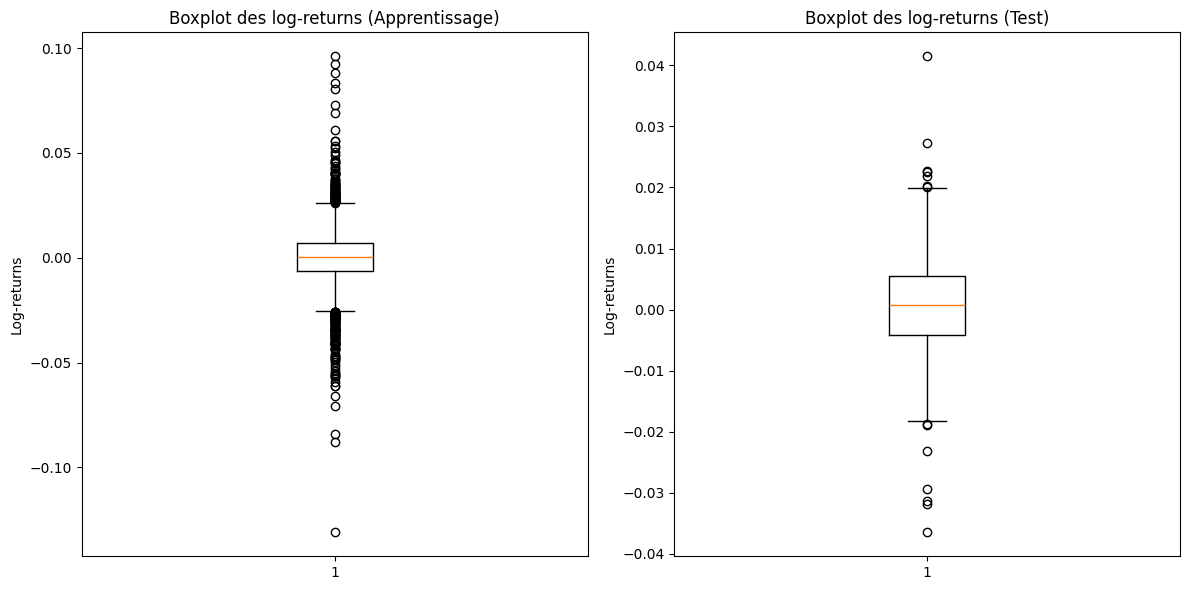

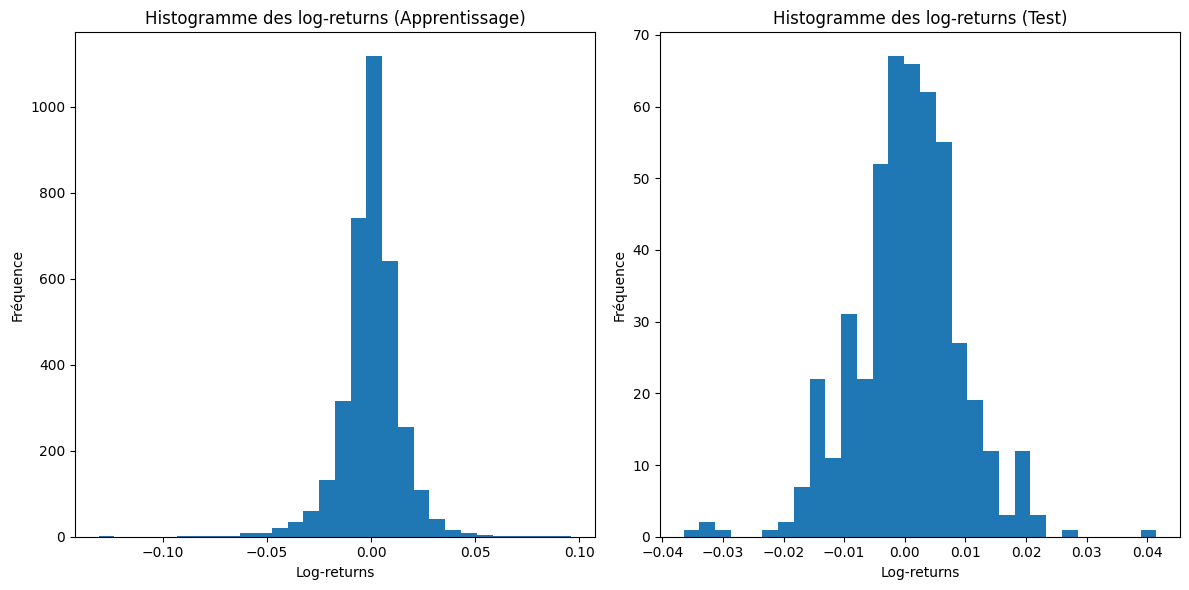

In [4]:

def analyze_train_test_data(df_train, df_test):
    """
    Analyse les jeux de données d'apprentissage et de test :
    - Affiche les statistiques descriptives
    - Génère des boxplots des log-returns
    - Génère des histogrammes des log-returns

    Paramètres :
    - df_train : DataFrame du jeu de données d'apprentissage
    - df_test : DataFrame du jeu de données de test
    """

    # Statistiques descriptives
    print("Statistiques descriptives du jeu de données d'apprentissage :")
    print(df_train.describe())
    print("\nStatistiques descriptives du jeu de données de test :")
    print(df_test.describe())

    # Boxplots des log-returns
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.boxplot(df_train['log_returns'].dropna())
    plt.title("Boxplot des log-returns (Apprentissage)")
    plt.ylabel("Log-returns")

    plt.subplot(1, 2, 2)
    plt.boxplot(df_test['log_returns'].dropna())
    plt.title("Boxplot des log-returns (Test)")
    plt.ylabel("Log-returns")

    plt.tight_layout()
    plt.show()

    # Histogrammes des log-returns
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df_train['log_returns'].dropna(), bins=30)
    plt.title("Histogramme des log-returns (Apprentissage)")
    plt.xlabel("Log-returns")
    plt.ylabel("Fréquence")

    plt.subplot(1, 2, 2)
    plt.hist(df_test['log_returns'].dropna(), bins=30)
    plt.title("Histogramme des log-returns (Test)")
    plt.xlabel("Log-returns")
    plt.ylabel("Fréquence")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Analyse
    analyze_train_test_data(df_train, df_test)


Il y a 3523 observations dans l'échantillon train, et 480 dans le test.

Nous observons que les distributions sont différentes (boxplot et histogramme). Sur l'échantillon train, nous observons des extrêmes plus forts, notamment dans les pertes. En effet, le minimum des log-rendements sur le train est de -0.130983, tandis qu'il est de -0.036484 sur le test.

Les deux distributions semblent être centrées autour de 0. Néanmoins, les queues de distributions sont bien différentes; elles sont plus épaisses sur l'ensemble test.

## Graphique superposant les 2
---

On cherche ici à superposer le log-rendement et le prix de clôture sur un même graphique.

Par ailleurs, les lignes en pointillés rouge délimitent l'ensemble train, tandis que celles enn vert délimitent l'échantillon test.

In [5]:


def plot_dual_axis_graph(df, ticker, train_start_date, train_end_date, test_start_date, test_end_date):
    """
    Génère un graphique Plotly avec deux axes Y :
    - Log-rendements en rouge (axe de gauche)
    - Prix de clôture en bleu (axe de droite)
    Le graphique est limité aux périodes entre le début du train et la fin du test.
    Des lignes pointillées indiquent les frontières des périodes d'entraînement et de test.

    Args:
        df (pd.DataFrame): Données avec 'Close' et 'log_returns'
        ticker (str): Symbole boursier
        train_start_date (str): Date de début de l'ensemble d'entraînement
        train_end_date (str): Date de fin de l'ensemble d'entraînement
        test_start_date (str): Date de début de l'ensemble de test
        test_end_date (str): Date de fin de l'ensemble de test

    Returns:
        fig (plotly.graph_objects.Figure): Graphique interactif
    """
    # Limiter le DataFrame aux dates d'entraînement et de test
    df_filtered = df[(df.index >= train_start_date) & (df.index <= test_end_date)]

    fig = go.Figure()

    # Log-rendements (rouge)
    fig.add_trace(go.Scatter(
        x=df_filtered.index,
        y=df_filtered['log_returns'],
        mode='lines',
        name='Log-rendements',
        line=dict(color='red')
    ))

    # Prix de clôture (bleu)
    fig.add_trace(go.Scatter(
        x=df_filtered.index,
        y=df_filtered['Close'],
        mode='lines',
        name='Prix de clôture',
        line=dict(color='blue'),
        yaxis="y2"
    ))

    # Ajouter des lignes pointillées pour les frontières des périodes
    fig.add_trace(go.Scatter(
        x=[train_start_date, train_start_date],
        y=[df_filtered['log_returns'].min(), df_filtered['log_returns'].max()],
        mode='lines',
        name='Début Train',
        line=dict(color='red', dash='dash')
    ))

    fig.add_trace(go.Scatter(
        x=[train_end_date, train_end_date],
        y=[df_filtered['log_returns'].min(), df_filtered['log_returns'].max()],
        mode='lines',
        name='Fin Train',
        line=dict(color='red', dash='dash')
    ))

    fig.add_trace(go.Scatter(
        x=[test_start_date, test_start_date],
        y=[df_filtered['log_returns'].min(), df_filtered['log_returns'].max()],
        mode='lines',
        name='Début Test',
        line=dict(color='green', dash='dash')
    ))

    fig.add_trace(go.Scatter(
        x=[test_end_date, test_end_date],
        y=[df_filtered['log_returns'].min(), df_filtered['log_returns'].max()],
        mode='lines',
        name='Fin Test',
        line=dict(color='green', dash='dash')
    ))

    # Mise en forme des axes
    fig.update_layout(
        title=f"Log-rendements et Prix de clôture de {ticker}",
        xaxis=dict(title="Date"),
        yaxis=dict(title="Log-rendements", color="red"),
        yaxis2=dict(
            title="Prix de clôture",
            overlaying="y",
            side="right",
            color="blue"
        ),
        template="plotly_white"
    )

    return fig


if __name__ == "__main__":
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Définir les dates pour l'ensemble de train et de test
    train_start_date = "2008-10-15"
    train_end_date = "2022-07-26"
    test_start_date = "2022-07-27"
    test_end_date = "2024-06-11"

    # Générer le graphique
    fig = plot_dual_axis_graph(df, "^FCHI", train_start_date, train_end_date, test_start_date, test_end_date)

    # Afficher le graphique
    fig.show()


# 1.VaR non paramétrique
---

La VaR est une mesure de risque qui donne une estimation de la perte maximale que l'on peut subir avec un certain niveau de confiance $\alpha$ sur un horizon de temps donné. Par exemple, une VaR à \alpha = 99% sur 1 jour de 1000 euros signifie que 99% du temps, on ne perdra pas plus de 1000 euros sur un jour.

$$P(\text{Loss} < \text{VaR}) = 1 - \alpha.$$

## Question a.

Ecrire une fonction calculant la VaR historique (à 1 jour) d'un ensemble de log-rendements ==> VaR_Hist(x, alpha)

---

La VaR historique estime le montant potentiel de perte d'un portefeuille sur un horizon donné (ici 1 jour) en se basant sur la distribution empirique des rendements passés, en utilisant un percentile spécifié (qui est le niveau de confiance 1-α avec α = 99% car nous voulons estimer les pertes à l'aide des rendements i.e. il faut regarder la queue de distribution gauche).

In [6]:

def VaR_Hist(x, alpha):
    """
    Calcule la VaR historique (à 1 jour) d'un ensemble de log-rendements en utilisant np.percentile.

    Args:
        x: Une série Pandas de log-rendements.
        alpha: Le niveau de confiance.

    Returns:
        La VaR historique.
    """

    # Convertit alpha en pourcentage pour np.percentile
    percentile = (1 - alpha) * 100

    # Calcule la VaR avec np.percentile
    return np.percentile(x.dropna(), percentile)

## Question b

Calculer la VaR historique sur base d'apprentissage pour alpha=99%

---

In [7]:
if __name__ == "__main__":
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train et test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calcul de la VaR historique
    alpha = 0.99
    var_train = VaR_Hist(df_train['log_returns'], alpha)

    print(f"VaR historique (niveau de confiance {alpha*100:.0f}%) sur les données d'apprentissage : {var_train*100:.4f}%")

VaR historique (niveau de confiance 99%) sur les données d'apprentissage : -4.0850%


La VaR historique au niveau de confiance de 99 % sur les données d'apprentissage indique que, sur la période analysée, la perte quotidienne maximale attendue ne dépasse pas 4,0850 % dans 99 % des cas, ce qui signifie qu'il y a seulement 1 % de chances de subir une perte plus importante que ce seuil sur un jour donné. Cette perte peut se produire 2 à 3 ans fois en une année (252 jours de trading).

## Question c

Ecrire une fonction calculant la VaR historique bootstrap d'un ensemble de log-rendements et donnant un IC de niveau alpha_IC de cette VaR (VaR_Hist_Bootstrap(x,alpha, B, alpha_IC) )

---

La VaR historique bootstrap est une méthode qui permet d'estimer la VaR en utilisant des techniques de rééchantillonnage avec remise (bootstrap) pour évaluer la variabilité de la VaR. Le principe consiste à générer un grand nombre d'échantillons bootstrap à partir des log-rendements observés, à calculer la VaR historique pour chaque échantillon, puis à utiliser la distribution de ces VaR pour estimer la VaR bootstrap (moyenne des VaR) et construire un intervalle de confiance autour de cette estimation. Cela permet de quantifier l'incertitude associée à la VaR historique en tenant compte de la variabilité des données.

In [8]:
def VaR_Hist_Bootstrap(x, alpha, B, alpha_IC=0.05):
    """
    Calcule la VaR historique bootstrap d'un ensemble de log-rendements et donne un intervalle de confiance.

    Args:
        x: Une série Pandas de log-rendements.
        alpha: Le niveau de confiance pour la VaR (par exemple, 0.95 pour un niveau de confiance de 95%).
        B: Le nombre de rééchantillonages bootstrap.
        alpha_IC: Le niveau de confiance pour l'intervalle de confiance (par exemple, 0.95 pour un intervalle de confiance de 95%).

    Returns:
        Un tuple contenant la VaR historique bootstrap, la borne inférieure de l'intervalle de confiance, et la borne supérieure de l'intervalle de confiance.
    """

    # set seed
    np.random.seed(42)

    # Initialisation du vecteur des VaR
    var = np.zeros(B)

    # Calcul de la VaR bootstrap
    for i in range(B):
        sample = np.random.choice(x, size=len(x), replace=True)
        var[i] = np.percentile(sample, 100*(1- alpha))

    # Calcul de l'intervalle de confiance
    lower = np.percentile(var, 100*(1-alpha_IC)/2)
    upper = np.percentile(var, 100*(alpha_IC + (1-alpha_IC)/2))

    return np.mean(var), lower, upper

## Question d

Calculer la VaR historique Bootstrap et l'IC associé à 90% sur base d'apprentissage pour alpha = 99%

---

Pour l'implémentation de la VaR bootstrap, nous faisons le choix de faire un tirage de taille n=la taille de la série des rendements, avec remise. Ce choix est fait pour des raisons de simplicité. En ce qui concerne le choix du nombre d'échantillons, nous allons observer l'évolution de de l'estimation de la VaR en fonction du nombre d'échantillons. Nous limiterons à des échantillons compris entre 1000 et 10000, pour des raisons de temps computationnels, en ayant conscience que plus le nombre d'échantillons est grand, plus l'estimation de la VaR sera précise.

In [9]:
# Observer la variation de la VaR en fonction de M
M_values = np.arange(1000, 10000, 10)
var_bs_values = []

for M in tqdm(M_values):
    var_bs_train, _, _ = VaR_Hist_Bootstrap(df_train["log_returns"], alpha=alpha, B=M)
    var_bs_values.append(var_bs_train)

100%|██████████| 900/900 [06:11<00:00,  2.42it/s]


Text(0.5, 1.0, 'Variation de la VaR bootstrap en fonction du nombre de simulations')

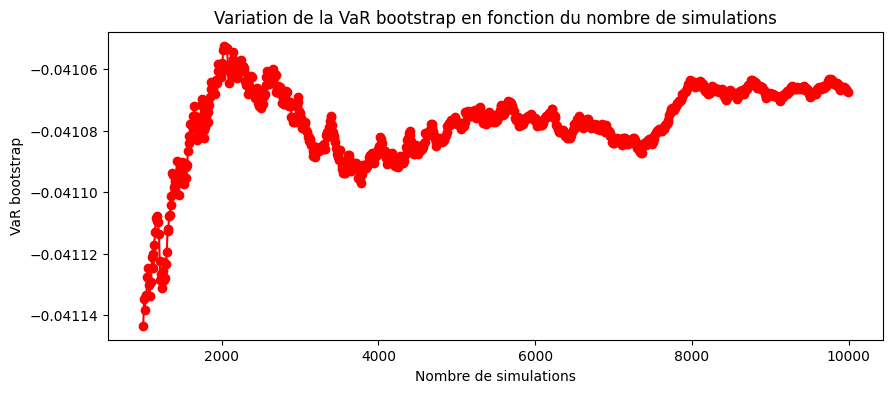

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(M_values, var_bs_values, marker='o', color='red')
plt.xlabel('Nombre de simulations')
plt.ylabel('VaR bootstrap')
plt.title("Variation de la VaR bootstrap en fonction du nombre de simulations")

Pour la taille de l'echantillon bootstrap, nous allons prendre M=8000 étant donné que la courbe semble se stabiliser à partir de cette valeur. Avec ce choix, la VaR estimé est de -4.11% avec un intervalle de confiance à 90% de [-4.38%, -3.83%]. De plus, en ce qui concerne la VaR historique, nous constatons que l'estimation est contenu dans l'intervalle de confiance.

In [11]:
if __name__ == "__main__":
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train et test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Affichage des résultats

    optimal_B=8000
    var_bs_train, lower_ic,upper_ic = VaR_Hist_Bootstrap(df_train["log_returns"], alpha=0.99, B=optimal_B)
    print(f"La VaR bootstrap pour h=1j et alpha=0.99 est : {var_bs_train:.4%}")
    print(f"L'intervalle de confiance est : [{lower_ic:.4%}, {upper_ic:.4%}]")

La VaR bootstrap pour h=1j et alpha=0.99 est : -4.1065%
L'intervalle de confiance est : [-4.0939%, -4.0536%]


## Question e

Calculer le nombre d'exceptions sur la base de test associées à la VaR historique calculée en 1.b

---

In [12]:
def count_var_exceptions(df_test, var_value):
    """
    Compte le nombre d'exceptions où les log-rendements sont inférieurs à la VaR.

    Paramètres :
    - df_test : DataFrame contenant les rendements de test.
    - var_value : Valeur de la VaR calculée.

    Retourne :
    - Nombre d'exceptions.
    """
    exceptions = df_test[df_test['log_returns'] < var_value]
    return len(exceptions)

if __name__ == "__main__":
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train et test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calcul de la VaR sur les données d'apprentissage
    alpha = 0.99
    var_train = VaR_Hist(df_train['log_returns'], alpha)

    # Calcul des exceptions sur la période de test
    nb_exceptions = count_var_exceptions(df_test, var_train)

    # Affichage du résultat
    print(f"Nombre d'exception(s) sur la période de test : {nb_exceptions}")


Nombre d'exception(s) sur la période de test : 0


Il y a 0 exception sur la période de test. Ce résultat est cohérent avec les histogrammes observés dans la partie préliminaire. Nous avions remarqué que le minimum des rendements était bien plus faible sur le train; ainsi, il n'est pas étonnant que la VaR sur ce même ensemble soit inférieure au minimum des log-rendements sur l'ensemble test.

## Question f

Comparer statistiquement ce % d'exceptions avec le niveau de risque attendu (aide : on pourra par exemple passer par un IC de binomiale)

---

Pour l'exercice de backtest, il s'agit de :
1. Déterminer si la proportion $p$ de violations de la VaR est cohérente avec le niveau de confiance, i.e. égale à $1-\alpha$. Cela permet de vérifier si la mesure de risque est bien calibrée. Pour cela, nous pouvons avoir recours à un test de proportion ou un test de ratio de vraisemblance.

    **Unconditional coverage test** :
    Soit I la variable indicatrice de violation de la VaR, i.e. $I=1$ si la perte est supérieure à la VaR, et $I=0$ sinon. La proportion de violations de la VaR est donnée par :

    $$p = \frac{1}{n} \sum_{i=1}^{n} I_i = \frac{Z}{n}$$

    Sous H0, i.e. p=1-$\alpha$, Z $\sim$ Binomiale(n, 1-$\alpha$). En supposant que n est suffisamment grand, on peut approximer Z par une loi normale. Ainsi donc :
    $$\frac{Z - n (1-\alpha)}{\sqrt{\alpha (1-\alpha) n}} \sim \mathcal{N}(n(1-\alpha), n\alpha(1-\alpha))$$

    Sous cette hypothèse asymptotique, on peut calculer la statistique du ratio de vraisemblance suivant :
    $$LR = -2 ln \left( \frac{L(H1)}{L(H0)} \right) =-2 ln \left( 1- (1-\alpha))^{n-e}(1-\alpha)^e \right) + 2 ln \left( (1-\frac{e}{n})^{n-e} (\frac{e}{n})^e  \right)  \sim \chi^2(1)$$

    où e est le nombre de violations de la VaR. On rejette H0 si LR > $\chi^2(1-\alpha)$.

    **Test de proportion** :
    $$
    H_0 : p = p_0 = 1-\alpha \\ H_1 : p > 1-\alpha
    $$
    On peut également utiliser un test binomial pour tester si la proportion de violations de la VaR est égale à $1-\alpha$. On peut calculer la statistique du test suivant :
    $$Z = \frac{p - p_0}{\sqrt{p_0 (1-p_0) / n}} \sim \mathcal{N}(0,1)$$

    On rejette H0 si Z > $p_0+ \phi^{-1}(1-\alpha) \sqrt{p_0 (1-p_0)/n}$, où $\phi$ est la quantile de la loi normale standard.

2. Déterminer si, lorsqu'il y en a, les violations de VaR à deux différents jours sont indépendantes. Cela permet si la mesure de risque est capable de réagir aux chocs de marché affectant la volatilité des rendements. Pour cela, nous utilisons un conditional coverage test.

In [13]:
# Objectif : implémenter une fonction calculant le nombre d'exception sur l'échantillon test
def exceptions(data, var):
    """
    Calcul du nombre d'exception
    data : les rendements logarithmiques
    var : la VaR
    """
    return np.sum(data < var)


# Objectif : test de proportion binomiale

def binomial_test(n, p, p0 = 0.01, alpha=0.05):
    """
    Test de proportion binomiale
    H0 : p = p0
    H1 : p > p0
    n : le nombre d'essais
    p : la proportion
    alpha : le niveau de confiance
    """

    z = (p - p0) / np.sqrt(p0 * (1 - p0) / n)
    #reject_zone = p0 + stats.norm.ppf(1 - alpha) * np.sqrt(p0 * (1 - p0) / n)
    p_value = 1 - stats.norm.cdf(z)
    reject = p_value < alpha

    # Calcul des IC
    lower = p - stats.norm.ppf(1 - alpha) * np.sqrt(p * (1 - p) / n)
    upper = p + stats.norm.ppf(1 - alpha) * np.sqrt(p * (1 - p) / n)

    return p_value, reject, lower, upper

In [14]:
if __name__ == "__main__":
  df = telecharger_donnees("^FCHI", "1992-01-01")

  df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

  # Backtest de la VaR historique
  alpha = 0.99
  var_train = VaR_Hist(df_train['log_returns'], alpha)

  exceptions_test = exceptions(df_test['log_returns'], var_train)
  print(f"Le nombre d'exceptions sur l'échantillon de test est : {exceptions_test}")

  print("="*80)
  n = len(df_test)
  p = exceptions_test / n
  p_value, reject, lower,upper = binomial_test(n, p)
  print(f"H0 : le nombre d'exceptions est inférieur ou égal à {1-alpha:.2%}")
  print(f"IC : [{lower:.2%},{upper:.2%}]")
  print(f"La p-value du test de proportion binomiale est : {p_value:.4f}")
  print(f"Rejet de l'hypothèse nulle : {reject}")
  print("="*80)


Le nombre d'exceptions sur l'échantillon de test est : 0
H0 : le nombre d'exceptions est inférieur ou égal à 1.00%
IC : [0.00%,0.00%]
La p-value du test de proportion binomiale est : 0.9862
Rejet de l'hypothèse nulle : False


Le nombre d'exception sur l'échantillon test est cohérent avec les analyses effectuées en analyses univariés sur les deux échantillons.

# 2.VaR gaussienne

---

* Principe : Il est très commun de supposer la normalité de la distribution des rendements $(r_{1|1+h}, \ldots, r_{T|T+h})$. On émet alors l’hypothèse que $R \sim N(\mu, \sigma^2)$ et on a  
$$
  \mathbb{P}[R \leq VaR_h(\alpha)] = \mathbb{P} \left[ \frac{R - \mu}{\sigma} \leq \frac{VaR_h(\alpha) - \mu}{\sigma} \right] = \phi \left( \frac{VaR_h(\alpha) - \mu}{\sigma} \right) = 1 - \alpha
$$

* Définition : En supposant que la rentabilité du portefeuille suit une loi normale, $R \sim N(\mu, \sigma^2)$, la VaR gaussienne de niveau α se définit par  
$$
  VaR_h(\alpha) = \mu + \sigma\phi^{-1}(1 - \alpha)
$$

* Calcul : On estime les paramètres de la loi à partir de l’échantillon  
$$
  \hat{\mu} = \mu(r_{1|1+h}, \ldots, r_{T|T+h}) \quad \text{et} \quad \hat{\sigma} = \sigma(r_{1|1+h}, \ldots, r_{T|T+h})
$$
  Et on obtient simplement  
$$
  \overline{VaR_h}(\alpha) = \hat{\mu} + \hat{\sigma}\phi^{-1}(1 - \alpha)
$$

* Rapide à mettre en place, simplicité de l’écriture de la VaR, hypothèse récurrente  
* Distribution symétrique à queues fines

## Question a

a.	Ecrire une fonction calculant la VaR gaussienne d’un ensemble de log-rendements (VaR_Gauss(x, alpha) )

---

In [15]:
def VaR_Gauss(x, alpha):
    """
    Calcule la VaR gaussienne (à 1 jour) d'un ensemble de log-rendements.

    Args:
        x: Une série Pandas de log-rendements.
        alpha: Le niveau de confiance (ex: 0.99 pour 99%).

    Returns:
        La VaR gaussienne.
    """
    # Calculer la moyenne et l'écart-type des log-rendements
    mu = np.mean(x.dropna())
    sigma = np.std(x.dropna())

    # Calculer le quantile correspondant au niveau de confiance alpha
    quantile = st.norm.ppf(1 - alpha)

    # Calculer la VaR gaussienne
    var_gauss = mu + sigma * quantile
    return var_gauss

## Question b

Calculer la VaR gaussienne sur base d’apprentissage pour alpha = 99%.

---

In [16]:
if __name__ == "__main__":
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train et test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calcul de la VaR gaussienne sur les données d'apprentissage
    alpha = 0.99
    var_gauss_train = VaR_Gauss(df_train['log_returns'], alpha)

    # Affichage du résultat
    print(f"VaR gaussienne (niveau de confiance de {alpha*100:.0f}%) sur les données d'apprentissage : {var_gauss_train*100:.4f}%")

VaR gaussienne (niveau de confiance de 99%) sur les données d'apprentissage : -3.2302%


Nous remarquon que cette VaR est bien supérieure à celles estimées auparavant par méthode historique ou encore par Bootstrap. Elle n'est pas même compris dans l'IC à 90%.

## Question c

Faire une validation ex-ante (analyses graphiques, QQ-plot, etc.)

---

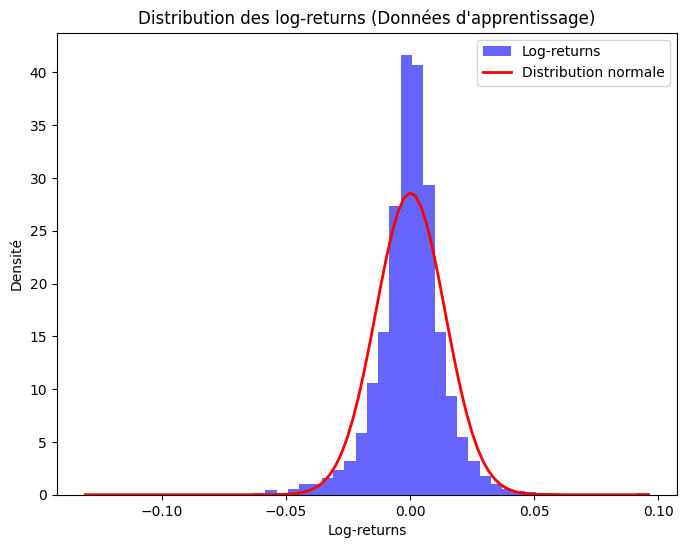

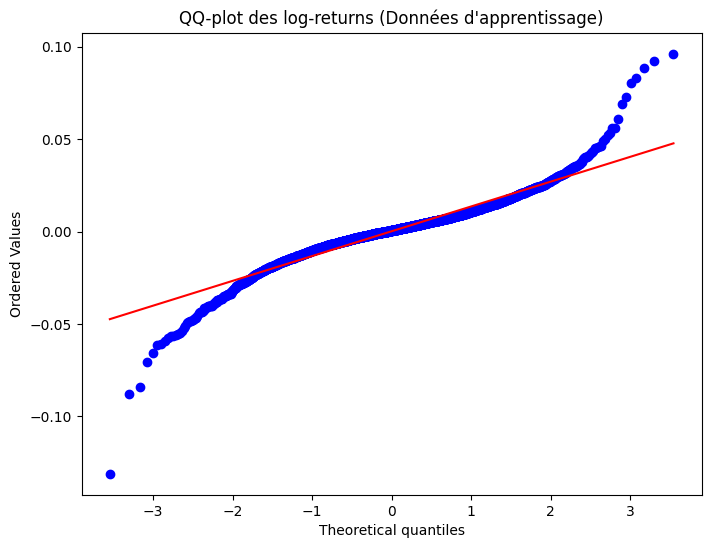

Skewness de l'échantillon d'entrainement :  Close          0.402999
log_returns   -0.298182
dtype: float64
Kurtosis de l'échantillon d'entrainement :  Close         -0.48316
log_returns    7.35396
dtype: float64
Test de Shapiro-Wilk: Statistique = 0.924, p-valeur = 0.000
On rejette l'hypothèse nulle: les données ne suivent pas une loi normale.


In [17]:
def analyze_log_returns(df_train):
    """
    Analyse graphique et statistique des log-returns :
    - Histogramme avec superposition de la loi normale
    - QQ-plot pour vérifier la normalité
    - Test de Shapiro-Wilk pour la normalité

    Args:
        df_train (pd.DataFrame): Données d'apprentissage avec colonne 'log_returns'
    """
    log_returns = df_train['log_returns'].dropna()

    # Histogramme avec densité normale
    plt.figure(figsize=(8, 6))
    plt.hist(log_returns, bins=50, density=True, alpha=0.6, color='b', label='Log-returns')
    plt.title('Distribution des log-returns (Données d\'apprentissage)')
    plt.xlabel('Log-returns')
    plt.ylabel('Densité')

    # Superposition de la loi normale
    mu, sigma = np.mean(log_returns), np.std(log_returns)
    x = np.linspace(min(log_returns), max(log_returns), 100)
    plt.plot(x, st.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Distribution normale')
    plt.legend()
    plt.show()

    # QQ-plot
    plt.figure(figsize=(8, 6))
    st.probplot(log_returns, dist="norm", plot=plt)
    plt.title('QQ-plot des log-returns (Données d\'apprentissage)')
    plt.show()
    # Skewness et kurtosis
    print("="*80)
    print("Skewness de l'échantillon d'entrainement : ", df_train.skew())
    print("Kurtosis de l'échantillon d'entrainement : ", df_train.kurt())
    print("="*80)

    # Test de Shapiro-Wilk
    shapiro_test = st.shapiro(log_returns)
    print(f"Test de Shapiro-Wilk: Statistique = {shapiro_test[0]:.3f}, p-valeur = {shapiro_test[1]:.3f}")

    # Interprétation du test
    alpha_test = 0.05  # Seuil de signification
    if shapiro_test[1] < alpha_test:
        print("On rejette l'hypothèse nulle: les données ne suivent pas une loi normale.")
    else:
        print("On ne rejette pas l'hypothèse nulle: les données pourraient suivre une loi normale.")

if __name__ == "__main__":
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Lancer l'analyse
    analyze_log_returns(df_train)

Visuellement, les données ne semblent pas suivre une loi normale. En effet, les quantiles théoriques d'une loi normale ne collent pas avec les quantiles empiriques des rendements (QQ-plot). Cela peut être dû à la présence de queues épaisses observables sur l'estimation de la densité des rendements sur l'échantillon d'apprentissage, de pics, de clusters de volatilité que nous avons observées plus haut. De plus, le skewness est négatif ce qui indique une asymétrie négative des rendements. Enfin, le kurtosis est supérieur à 3, ce qui indique une distribution leptokurtique des rendements.

L'hypothèse nulle du test de Shapiro est également rejettée, signifiant que statistiquement, les données ne suivent pas une loi normale. Nous aurions également pu vérifier cela à l'aide d'un test de Kolmogorov-Smirnov.

## Question d
Calculer la VaR gaussienne à 10j par la méthode du scaling

---

Pour étendre la VaR gaussienne à un horizon de plusieurs jours, on utilise la méthode de scaling, qui repose sur l'hypothèse que les rendements sont indépendants et identiquement distribués (i.i.d.). Cette méthode permet de passer d'une VaR à 1 jour à une VaR à h jours en multipliant par la racine carrée de l'horizon temporel h, conformément à la propriété de la variance dans un processus i.i.d.

In [18]:
def VaR_Gauss_Scaling(var_gauss_1d, horizon=10):
    """
    Calcule la VaR gaussienne à un horizon de plusieurs jours en utilisant la méthode de scaling.

    Args:
        var_gauss_1d (float): VaR gaussienne à 1 jour.
        horizon (int): Nombre de jours pour la VaR (par défaut 10 jours).

    Returns:
        float: VaR gaussienne à l'horizon donné.
    """
    return np.sqrt(horizon) * var_gauss_1d

if __name__ == "__main__":
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calcul de la VaR gaussienne à 1 jour
    alpha = 0.99
    var_gauss_train = VaR_Gauss(df_train['log_returns'], alpha)

    # Calcul de la VaR gaussienne à 10 jours avec scaling
    var_gauss_10d = VaR_Gauss_Scaling(var_gauss_train, horizon=10)

    # Affichage des résultats
    print(f"VaR gaussienne à 1 jour (niveau de confiance {alpha*100:.0f}%) : {var_gauss_train*100:.4f}%")
    print(f"VaR gaussienne à 10 jours (niveau de confiance {alpha*100:.0f}%) : {var_gauss_10d*100:.4f}%")


VaR gaussienne à 1 jour (niveau de confiance 99%) : -3.2302%
VaR gaussienne à 10 jours (niveau de confiance 99%) : -10.2148%


La VaR gaussienne à 1 jour, avec un niveau de confiance de 99 %, indique que la perte quotidienne maximale attendue est de -3,2302 %, ce qui signifie qu'il y a seulement 1 % de chances de subir une perte plus importante que ce seuil sur un jour donné. En étendant cette mesure à un horizon de 10 jours grâce à la méthode de scaling, la VaR gaussienne à 10 jours atteint -10,2148 %, reflétant une perte maximale attendue plus élevée sur une période plus longue, tout en conservant le même niveau de confiance de 99 %. Cela illustre l'impact de l'horizon temporel sur le risque de perte.

## Question e

Calculer la VaR gaussienne à 10j par méthode de diffusion d’un actif.
dS=S.μ.dt + S.σ.Z.√dt       avec     Z ~N(0,1)
On pourra considérer :


*   S_0 comme la valeur du cours de clôture à la dernière date de l'échantillon d'apprentissage
*   dt=1jour
*   μ et σ les paramètres estimés en 2.b

Pour calculer la VaR gaussienne à 10 jours par **méthode de diffusion d’un actif**, nous allons suivre les étapes suivantes :

L'évolution du prix d'un actif suit un processus de type mouvement brownien géométrique :
$$
dS_t = \mu S_t dt + \sigma S_t dW_t <=> S_t = S_{t-1} e^{(\mu - \frac{1}{2} \sigma^2) + \sigma W_t}
$$
où $ S_t$ est le prix de l'actif à l'instant$ t$, $ \mu$ est le rendement moyen estimé (drift), $ \sigma$ est la volatilité du rendement, $ dW_t$ est un mouvement brownien standard.


On peut de ce fait calculer plusieurs trajectoires de rendements de $S_0$ et $S_{10}$, puis calculer la VaR à partir de la série des rendements $ r_{10j} = \ln(S_{10} / S_{0}) $ obtenus avec ces trajectoires.

En utilisant la méthode de scaling et la méthode de diffusion, nous obtenons sensiblement la même VaR.


In [19]:
def VaR_Gauss_Diffusion(S_0, mu, sigma, alpha, horizon=10, dt=1):
    """
    Calcule la VaR gaussienne à plusieurs jours en utilisant la méthode de diffusion.

    Args:
        S_0 (float): Dernier prix observé.
        mu (float): Espérance des log-rendements.
        sigma (float): Volatilité des log-rendements.
        alpha (float): Niveau de confiance (ex: 0.99 pour 99%).
        horizon (int): Nombre de jours pour la VaR (par défaut 10 jours).
        dt (float): Pas de temps (1 jour par défaut).

    Returns:
        float: VaR gaussienne par diffusion.
    """
    quantile_alpha = st.norm.ppf(1 - alpha)
    var_diffusion = np.exp((mu - 0.5 * sigma**2) * horizon * dt + sigma * np.sqrt(horizon * dt) * quantile_alpha) - 1
    return var_diffusion

if __name__ == "__main__":
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Récupération des paramètres
    S_0 = df_train['Close'].iloc[-1]
    mu = np.mean(df_train['log_returns'].dropna())
    sigma = np.std(df_train['log_returns'].dropna())
    alpha = 0.99
    horizon = 10

    # Calcul de la VaR par diffusion
    var_diffusion_10d = VaR_Gauss_Diffusion(S_0, mu, sigma, alpha, horizon)

    # Affichage des résultats
    print(f"VaR gaussienne à {horizon} jours (diffusion) : {var_diffusion_10d*100:.4f}%")


VaR gaussienne à 10 jours (diffusion) : -9.7041%


## Question f

Ecrire une fonction calculant la VaR gaussienne à 1j d’un ensemble de log-rendements en surpondérant les observations les plus récentes selon la méthode EWMA (Exponential Weighting Moving Average)

---

Une fois les paramètres EWMA (moyenne $\hat{\mu}(\lambda)$ et écart-type $\hat{\sigma}(\lambda)$) calculés, on utilise ces valeurs pour estimer la VaR gaussienne à 1 jour. La formule de la VaR gaussienne intègre la moyenne et l'écart-type pondérés exponentiellement, en tenant compte du niveau de confiance α via le quantile de la loi normale $\Phi^{-1}(\alpha)$ :

$$
VaR = \hat{\mu}(\lambda) + \Phi^{-1}(\alpha) \cdot \hat{\sigma}(\lambda)
$$

Cette approche permet de surpondérer les observations les plus récentes, reflétant ainsi plus fidèlement les conditions de marché actuelles dans l'estimation du risque.

In [20]:



def compute_EWMA_params(returns, lambd):
    """
    Calcule la moyenne et la variance pondérées EWMA.

    Paramètres :
        returns : np.array
            Série des rendements passés
        lambd : float
            Facteur d'lissage EWMA (ex: 0.94, 0.95, 0.99)

    Retour :
        mu_lambda : float
            Moyenne pondérée EWMA
        sigma_lambda : float
            Écart-type pondéré EWMA
    """
    T = len(returns)  # Taille de l'historique
    weights = np.array([(lambd**i) * (1 - lambd) for i in range(T)])  # Poids EWMA
    weights /= np.sum(weights)  # Normalisation des poids

    # Calcul de la moyenne pondérée exponentielle
    mu_ewma = np.sum(weights * returns[::-1])

    # Calcul de la variance pondérée exponentielle
    sigma_ewma = np.sqrt(np.sum(weights * (returns[::-1] - mu_ewma) ** 2))

    return mu_ewma, sigma_ewma

def VaR_Gauss_EWMA(returns, alpha, lambd):
    """
    Calcule la VaR gaussienne à 1 jour en utilisant la méthode EWMA.

    Paramètres :
        returns : np.array
            Série des rendements passés
        alpha : float
            Niveau de confiance (ex: 0.99 pour 99%)
        lambd : float
            Facteur d'lissage EWMA (ex: 0.94, 0.95, 0.99)

    Retour :
        VaR : float
            La valeur à risque (VaR) estimée
    """
    mu_lambda, sigma_lambda = compute_EWMA_params(returns, lambd)
    VaR = mu_lambda + norm.ppf(alpha) * sigma_lambda  # Intégration de la moyenne EWMA
    return VaR


## Question g

Pour lamba = 0.9, 0.95 et 0.99 :
* Calculer les paramètres $\hat{\mu}(λ)$ et $\hat{\sigma^2} (λ)$
* Calculer les VaR gaussienne EWMA sur base d’apprentissage pour alpha = 99%.
* Calculer le nombre d’exceptions sur base de test.

---


In [21]:
def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Définition des paramètres
    lambdas = [0.9, 0.95, 0.99]
    alpha = 0.01  # Pour alpha = 99%, on utilise 0.01

    for lambd in lambdas:
        # i. Calculer les paramètres 𝜇̂(𝜆) et 𝜎̂2(𝜆)
        mu_lambda, sigma_lambda = compute_EWMA_params(df_train['log_returns'].values, lambd)
        print(f"Pour lambda = {lambd:.2f}:")
        print(f"  mu_hat(lambda) = {mu_lambda:.6f}")
        print(f"  sigma_hat(lambda) = {sigma_lambda:.6f}")

        # ii. Calculer la VaR gaussienne EWMA sur base d’apprentissage
        var_ewma = VaR_Gauss_EWMA(df_train['log_returns'].values, alpha, lambd)
        print(f"  VaR EWMA (alpha = {alpha}) = {var_ewma*100:.4f}%")

        # iii. Calculer le nombre d’exceptions sur base de test
        exceptions = df_test[df_test['log_returns'] < var_ewma]
        nb_exceptions = len(exceptions)
        print(f"  Nombre d'exceptions sur la période de test : {nb_exceptions}")
        print("-" * 20)

if __name__ == "__main__":
    main()


Pour lambda = 0.90:
  mu_hat(lambda) = 0.001898
  sigma_hat(lambda) = 0.011025
  VaR EWMA (alpha = 0.01) = -2.3751%
  Nombre d'exceptions sur la période de test : 4
--------------------
Pour lambda = 0.95:
  mu_hat(lambda) = 0.000735
  sigma_hat(lambda) = 0.012768
  VaR EWMA (alpha = 0.01) = -2.8969%
  Nombre d'exceptions sur la période de test : 4
--------------------
Pour lambda = 0.99:
  mu_hat(lambda) = -0.000321
  sigma_hat(lambda) = 0.014267
  VaR EWMA (alpha = 0.01) = -3.3511%
  Nombre d'exceptions sur la période de test : 1
--------------------


Avec la méthode EWMA, nous observons que plus la VaR diminue, plus $\lambda$ augmente. Cela est dû au fait que plus $\lambda$ est grand, plus les rendements récents sont surpondérés, et donc la volatilité est plus faible, en raison de la fin de la période d'apprentissage.

# 3.VaR skew-Student


## Question a

Ecrire une fonction permettant d’estimer les paramètres d’une loi de Skew Student par maximum de vraisemblance.

On procédera par étapes : fonction de densité, fonction de log-vraisemblance, fonction d’optimisation.

On pourra utiliser le package scipy.optimize et la fonction minimize.

---

### Fonction de densité

*Loi de Student généralisée*
Soient $U \sim N(0,1)$ et $V \sim \chi^2(v)$, alors  
$$
T = \frac{U}{\sqrt{V/v}} \sim \mathcal{F}_v
$$
de densité  

$$
f_v(x) = \frac{1}{\sqrt{v\pi}} \frac{\Gamma\left(\frac{v+1}{2}\right)}{\Gamma\left(\frac{v}{2}\right)} \left[ 1 + \frac{x^2}{v} \right]^{-\frac{v+1}{2}}
$$

*Loi de Skew-Student*

Soient $T_{g,1}, T_{g,2}$ deux variables aléatoires indépendantes de loi $T_{0,1,v}$ et $y \in \mathbb{R}$, alors

$$
Z = \mu + \frac{\sigma}{\sqrt{1 + y^2}} (y|T_{g,1}| + T_{g,2})
$$

suit une loi skew Student, que l’on note $Z \sim ST_{\mu,\sigma,y,v} $, de densité

$$
f_{\mu,\sigma,y,v}(x) = 2f_{\mu,\sigma,v}(x)F_{\nu+1} \left( y \frac{x - \mu}{\sigma} \sqrt{\frac{v + 1}{\left(\frac{x - \mu}{\sigma}\right)^2 + v}} \right)
$$

In [22]:


def skew_student_pdf(x, mu, sigma, gamma, nu):
    """
    Fonction de densité de probabilité de la loi skew-Student.
    """
    z = (x - mu)/sigma
    # Calcul de la fonction de densité de la loi Student généralisée
    #from the scipy.stats documentation : t.pdf(x, df, loc, scale) is identically equivalent to t.pdf(y, df) / scale with y = (x - loc) / scale
    pdf_student = t.pdf(z, df=nu) / sigma

    # Calcul de la fonction de répartition de la loi Student (nu + 1 degrés de liberté)
    cdf_student = st.t.cdf(gamma *z*np.sqrt((nu + 1)/(nu + z**2)), df=nu + 1)

    # Fonction de densité de la loi skew-Student
    pdf_skew_student = 2 * pdf_student * cdf_student

    return pdf_skew_student

### Fonction de log-vraisemblance

In [23]:
def log_likelihood_skew_student(params, x):
    """
    Fonction de log-vraisemblance pour la loi skew-student.
    """
    mu, sigma, gamma, nu = params

    # Vérification des contraintes sur les paramètres
    if sigma <= 0 or nu <= 0:
        return -np.inf  # Retourne -infini si les contraintes ne sont pas respectées

    log_likelihood = np.sum(np.log(skew_student_pdf(x, mu, sigma, gamma, nu)))
    return -log_likelihood  # On retourne l'opposé pour la minimisation

### Fonction d'optimisation

In [24]:

def estimate_skew_student_params(x):
    """
    Estime les paramètres d'une loi skew-Student par maximum de vraisemblance.
    """

    # Initialisation des paramètres
    initial_params = [np.mean(x), np.std(x), 0, 5]  # Valeurs initiales pour mu, sigma, gamma, nu

    # Bornes des paramètres
    bounds = [(None, None), (1e-6, None), (None, None), (1e-6, None)] # sigma > 0, nu > 0

    # Optimisation
    result = minimize(log_likelihood_skew_student, initial_params, args=(x,), bounds=bounds)

    # Vérification de la convergence
    if not result.success:
        print(f"Optimization failed: {result.message}")
        return None

    return result.x

## Question b

Estimer les paramètres de loi Skew Student sur base d’apprentissage.

---

In [25]:
def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Estimation des paramètres de la loi Skew-Student sur les données d'apprentissage
    estimated_params = estimate_skew_student_params(df_train['log_returns'].dropna())

    if estimated_params is not None:
        mu_hat, sigma_hat, gamma_hat, nu_hat = estimated_params
        print(f"Paramètres estimés de la loi Skew-Student :")
        print(f"  mu_hat = {mu_hat:.4f}")
        print(f"  sigma_hat = {sigma_hat:.4f}")
        print(f"  gamma_hat = {gamma_hat:.4f}")
        print(f"  nu_hat = {nu_hat:.4f}")
    else:
        print("L'optimisation a échoué. Vérifiez les données ou les paramètres initiaux.")

if __name__ == "__main__":
    main()


Paramètres estimés de la loi Skew-Student :
  mu_hat = 0.0023
  sigma_hat = 0.0088
  gamma_hat = -0.2318
  nu_hat = 2.9618


Pour la loi skew-student, nous estimons les paramètres ($\mu = 0.002, \sigma = 0.009, \gamma = -0.23, \nu = 2.96$). Le $\mu$ est le rendement moyen, $\sigma$ est l'écart-type, $\gamma$ est le coefficient d'asymétrie et $\nu$ est le degré de liberté. Le skewness est négatif, ce qui indique une asymétrie négative des rendements, comme ce qu'on a observé plus haut.

## Question c
Faire une validation ex-ante par QQ-plot.

---

Pour répondre à la question, nous implémentons d'abord une fonction permettant de calculer les quantiles de la distribution. Cela nous servira par la suite pour afficher le QQ-plot en calculant les quantiles théoriques.

In [26]:

def inverse_cdf(var, p):
    """
    Trouve la valeur x telle que F(x) = p pour une distribution Skew-Student
    basée sur les paramètres estimés à partir des rendements var.

    Paramètres :
    - var : Une série de données (par exemple les rendements des actifs)
    - p : La probabilité à laquelle on veut inverser la CDF (entre 0 et 1)

    Retourne :
    - La valeur de x telle que F(x) = p
    """
    # Estimation des paramètres de la loi Skew-Student à partir des données var
    estimated_params = estimate_skew_student_params(var)

    if estimated_params is not None:
        mu_hat, sigma_hat, gamma_hat, nu_hat = estimated_params

        # Fonction de la CDF (intégrale de la PDF)
        def cdf(x):
            return spi.quad(lambda t: skew_student_pdf(t, mu_hat, sigma_hat, gamma_hat, nu_hat), -np.inf, x)[0]

        # Vérification que p est entre 0 et 1
        if not (0 < p < 1):
            raise ValueError("p doit être entre 0 et 1")

        # Trouver la valeur de x telle que F(x) = p
        return spo.root_scalar(lambda x: cdf(x) - p, bracket=[-5, 10]).root
    else:
        raise ValueError("Les paramètres estimés sont None.")

Nous pouvons maintenant afficher le QQ-plot :

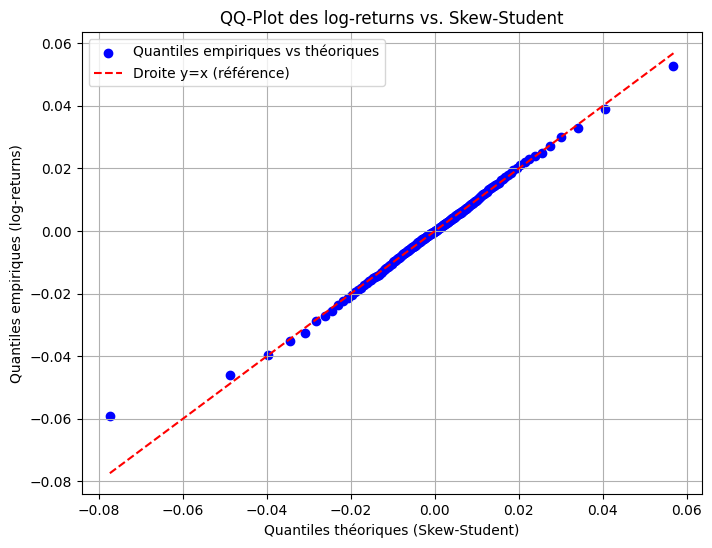

In [27]:

def plot_qq_skew_student(df_train):
    """
    Trace un QQ-Plot des log-returns par rapport à la loi Skew-Student estimée.

    Paramètres :
    - df_train : pd.DataFrame
        Les données d'entraînement, avec une colonne 'log_returns' contenant les rendements log.
    """
    # Extraire les données sans NaN
    log_returns = np.sort(df_train['log_returns'].dropna().values)
    n = len(log_returns)

    # Définir les niveaux de quantiles avec un pas de 0.005
    niveaux_quantiles = np.arange(0.002, 1, 0.005)

    # Calculer les quantiles empiriques pour les niveaux de quantiles définis
    quantiles_empiriques = np.quantile(log_returns, niveaux_quantiles)

    # Calculer les quantiles théoriques pour les probabilités données
    quantiles_theoriques = np.array([inverse_cdf(df_train['log_returns'], p) for p in niveaux_quantiles])

    # Tracer le QQ-plot
    plt.figure(figsize=(8, 6))
    plt.scatter(quantiles_theoriques, quantiles_empiriques, color="blue", label="Quantiles empiriques vs théoriques")
    plt.plot(quantiles_theoriques, quantiles_theoriques, color="red", linestyle="--", label="Droite y=x (référence)")

    plt.xlabel("Quantiles théoriques (Skew-Student)")
    plt.ylabel("Quantiles empiriques (log-returns)")
    plt.title("QQ-Plot des log-returns vs. Skew-Student")
    plt.legend()
    plt.grid()
    plt.show()

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Tracer le QQ-Plot
    plot_qq_skew_student(df_train)

if __name__ == "__main__":
    main()

En observant le QQ-plot, on constate que les quantiles théoriques de la skew-student collent bien avec les quantiles empiriques des rendements. Cela confirme que la skew-student est une bonne approximation de la distribution des rendements.
Pour une validation plus rigoureuse, on peut utiliser un test de Kolmogorov-Smirnov pour tester si les rendements suivent une loi skew-student.

## Question d

Comparer la qualité de fit entre loi gaussienne et loi de skew Student par analyse graphique.

---

Paramètres estimés de la loi Skew-Student :
  mu_hat = 0.002324589215562761
  sigma_hat = 0.008823892836954325
  gamma_hat = -0.23180873884422756
  nu_hat = 2.9618449046762074


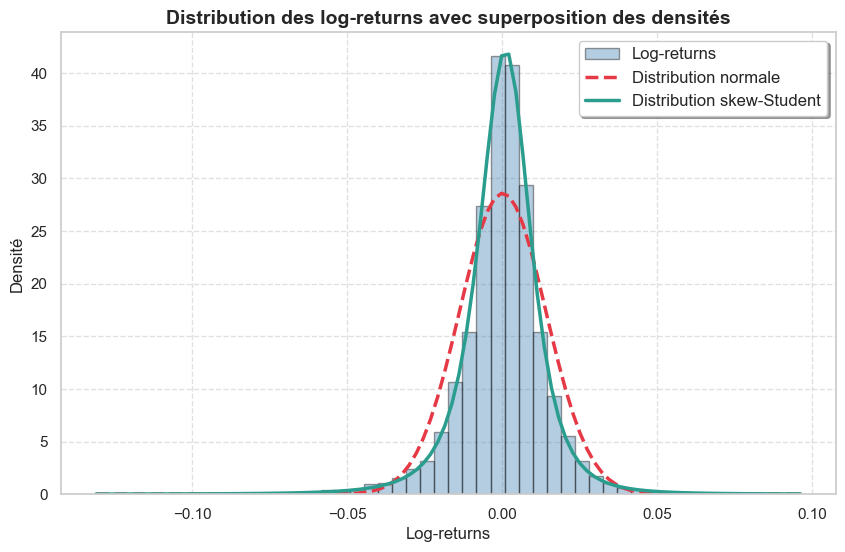

In [28]:
def plot_log_returns_distribution(df_train, mu_hat, sigma_hat, gamma_hat, nu_hat):
    """
    Trace l'histogramme des log-returns et superpose les densités de la loi normale et de la loi Skew-Student.

    Paramètres :
    - df_train : pd.DataFrame
        Les données d'entraînement contenant une colonne 'log_returns'.
    - mu_hat, sigma_hat, gamma_hat, nu_hat : float
        Paramètres estimés de la distribution Skew-Student.
    """
    # Appliquer un style seaborn
    sns.set(style="whitegrid")

    # Calcul de la moyenne et de l'écart-type pour la loi normale
    mu = np.mean(df_train['log_returns'].dropna())
    sigma = np.std(df_train['log_returns'].dropna())

    # Définition des valeurs de x pour les courbes de densité
    x = np.linspace(min(df_train['log_returns'].dropna()), max(df_train['log_returns'].dropna()), 100)

    # Création de la figure
    plt.figure(figsize=(10, 6))

    # Histogramme des log-returns
    plt.hist(df_train['log_returns'].dropna(), bins=50, density=True, alpha=0.4,
             color='#4682B4', edgecolor='black', label='Log-returns')

    # Superposition de la densité normale
    plt.plot(x, st.norm.pdf(x, mu, sigma), color='#E63946', lw=2.5, linestyle='dashed', label='Distribution normale')

    # Superposition de la densité skew-student
    plt.plot(x, skew_student_pdf(x, mu_hat, sigma_hat, gamma_hat, nu_hat), color='#2A9D8F', lw=2.5,
             label='Distribution skew-Student')

    # Ajout de la légende
    plt.legend(frameon=True, shadow=True, fontsize=12)

    # Titres et labels plus lisibles
    plt.title("Distribution des log-returns avec superposition des densités", fontsize=14, fontweight='bold')
    plt.xlabel("Log-returns", fontsize=12)
    plt.ylabel("Densité", fontsize=12)

    # Ajout d'une grille subtile
    plt.grid(True, linestyle="--", alpha=0.6)

    # Affichage du graphique
    plt.show()

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Estimation des paramètres de la loi Skew-Student
    estimated_params = estimate_skew_student_params(df_train['log_returns'].dropna())

    if estimated_params is not None:
        mu_hat, sigma_hat, gamma_hat, nu_hat = estimated_params
        print(f"Paramètres estimés de la loi Skew-Student :")
        print(f"  mu_hat = {mu_hat}")
        print(f"  sigma_hat = {sigma_hat}")
        print(f"  gamma_hat = {gamma_hat}")
        print(f"  nu_hat = {nu_hat}")

        # Tracer la distribution des log-returns avec les densités superposées
        plot_log_returns_distribution(df_train, mu_hat, sigma_hat, gamma_hat, nu_hat)
    else:
        print("L'optimisation a échoué. Vérifiez les données ou les paramètres initiaux.")

if __name__ == "__main__":
    main()


La densité théorique de la skew-student semble bien s'ajuster aux données. Elle capture mieux la variabilité de nos données, et s'adapte bien mieux aux queues de distribution que la loi normale.

## Question e

Calculer la VaR Skew Student sur base d’apprentissage pour alpha = 99%.

---

Nous avons implémenté auparavant une fonction quantile pour la distribution Skew Student.
Par définition, pour calculer la VaR Skew Student, il nous suffit de prendre le quantile à 1 - 99% = 1% (les pertes au niveau des rendements sur à gauche).

In [29]:
def calculate_var_student(var, alpha=0.99):
    """
    Calcule la Value at Risk (VaR) basée sur la distribution Skew-Student
    pour un niveau de confiance donné.

    Paramètres :
    - df_train : pd.DataFrame
        Les données d'entraînement contenant une colonne 'log_returns'.
    - alpha : float (par défaut 0.99)
        Niveau de confiance pour la VaR (ex : 0.99 pour une VaR à 99%).

    Retourne :
    - La VaR calculée.
    """
    # Calcul de la VaR comme le quantile correspondant de la distribution Skew-Student
    VaR_student = inverse_cdf(var, 1 - alpha)
    return VaR_student

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calcul de la VaR Skew-Student à 99% de confiance
    alpha = 0.99
    VaR_student_99 = calculate_var_student(df_train['log_returns'], alpha)

    # Affichage du résultat
    print(f"La VaR Skew-Student à {alpha * 100:.0f}% de confiance est : {VaR_student_99*100:.4f}%")

if __name__ == "__main__":
    main()


La VaR Skew-Student à 99% de confiance est : -4.2575%


# 4.Expected Shortfall

* Calculer l’ES empirique associé à la mesure faite en 1.b sur la base des données observées
* Calculer
  * L’ES empirique associé à la mesure faite en 2.b sur la base des données observées
  * L’ES théorique associé à la mesure faite en 2.b sur la base de la loi calibrée
* Calculer
  * L’ES empirique associé à la mesure faite en 3.e sur la base des données observées
  * L’ES théorique associé à la mesure faite en 3.e sur la base de la loi calibrée

---

L'Expected Shortfall (ES) mesure la perte moyenne attendue dans les pires cas, au-delà d'un certain seuil de confiance. Il est défini comme la moyenne des pertes qui dépassent la VaR.

* Pour un niveau de confiance $\alpha, l'Expected Shortfall (ES) empirique est simplement la moyenne des observations inférieures à la VaR. Il est calculé comme suit :

$$
ES_{\alpha} = \frac{1}{N_{tail}} \sum_{i=1}^{N_{tail}} x_i \quad \text{où} \quad x_i \leq VaR_{\alpha}
$$

où :
  * $N_{tail}$ est le nombre d'observations dans la queue de distribution inférieure à la VaR.
  * $x_i$ sont les rendements observés.

L'ES théorique, quant à lui, est calculé en utilisant la distribution calibrée (par exemple, Gaussienne ou Skew-Student) :

$$
ES_{\alpha} = \frac{1}{1 - \alpha} \int_{-\infty}^{VaR_{\alpha}} x \cdot f(x) \, dx
$$

où f(x) est la densité de probabilité des rendements.

In [30]:


# Fonction pour calculer l'ES empirique
def ES_empirique(x, VaR):
    """
    Calcule l'Expected Shortfall empirique en prenant la moyenne des rendements inférieurs à la VaR.

    Args:
        x: Une série Pandas de log-rendements.
        VaR: La valeur de la VaR associée à alpha.

    Returns:
        L'ES empirique.
    """
    log_returns_below_VaR = x[x < VaR]
    return log_returns_below_VaR.mean()

# Fonction pour calculer l'ES théorique à partir d'une distribution donnée
def ES_theorique(alpha, VaR, pdf_func):
    """
    Calcule l'Expected Shortfall théorique via l'intégrale de la densité.

    Args:
        alpha: Le niveau de confiance (par exemple, 0.01 pour 1%).
        VaR: La valeur de la VaR à partir de laquelle on calcule l'ES.
        pdf_func: La fonction de densité de probabilité (PDF) de la distribution.

    Returns:
        L'ES théorique.
    """
    def integrand(x):
        return x * pdf_func(x)

    integral_value, _ = spi.quad(integrand, -np.inf, VaR)
    return integral_value / (1 - alpha)

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Niveau de confiance
    alpha = 0.99

    # Calcul des VaR
    var_gauss = VaR_Gauss(df_train['log_returns'], alpha)
    var_hist = VaR_Hist(df_train['log_returns'], alpha)
    var_student = calculate_var_student(df_train['log_returns'], alpha)

    # Calcul des ES empiriques
    es_emp_gauss = ES_empirique(df_train['log_returns'], var_gauss)
    es_emp_hist = ES_empirique(df_train['log_returns'], var_hist)
    es_emp_student = ES_empirique(df_train['log_returns'], var_student)

    # Estimation des paramètres Skew-Student pour l'ES théorique
    mu_hat, sigma_hat, gamma_hat, nu_hat = estimate_skew_student_params(df_train['log_returns'].dropna())

    def pdf_gauss(x):
        return st.norm.pdf(x, loc=np.mean(df_train['log_returns']), scale=np.std(df_train['log_returns']))

    def pdf_skew_student(x):
        return skew_student_pdf(x, mu_hat, sigma_hat, gamma_hat, nu_hat)

    # Calcul des ES théoriques
    es_theo_gauss = ES_theorique(alpha, var_gauss, pdf_gauss)
    es_theo_student = ES_theorique(alpha, var_student, pdf_skew_student)

   # Affichage des résultats dans un DataFrame
    es_emp = pd.DataFrame({
        'Historique': [es_emp_hist],
        'Gaussienne': [es_emp_gauss],
        'Skew-Student': [es_emp_student]
    }, index=['ES empirique'])

    es_theo = pd.DataFrame({
        'Gaussienne': [es_theo_gauss],
        'Skew-Student': [es_theo_student]
    }, index=['ES théorique'])

    print("=" * 80)
    print("Expected Shortfall empirique (en %) pour h=1j")
    print(round(100 * es_emp, 4))
    print("=" * 80)

    print("Expected Shortfall théorique (en %) pour h=1j")
    print(round(100 * es_theo, 4))
    print("=" * 80)

if __name__ == "__main__":
    main()


Expected Shortfall empirique (en %) pour h=1j
              Historique  Gaussienne  Skew-Student
ES empirique     -5.4659     -4.4658       -5.6805
Expected Shortfall théorique (en %) pour h=1j
              Gaussienne  Skew-Student
ES théorique     -3.7029       -6.7074


L'approche par la distribution Skew-Student semble mieux capturer les risques extrêmes, tandis que la méthode Gaussienne sous-estime le risque.

# 5.Protocole de backtesting

---

L'exercice de backtesting consiste à vérifier la capacité d'adaptation du modèle et sa viabilité en dehors de son cadre d'entraînement. Il permet d’évaluer la performance des modèles dans le temps. Idéalement, il faudrait le realiser quotidiennement afin d'évaluer s'il est utile ou non de recalibrer le modèle.

Dans le cadre de TP, nous n'avons pas observé d'exceptions avec l'utilisation de la VaR historique. Cela est probablement du à la période d’apprentissage trop stricte. Notre modèle était donc trop restrictif/conservateur ce qui peut témoigner de son incapacité d'adaptation. Pour ce faire, il aurait été necessaire de le recalibrer.

Sachant que les modèles sont évalués quotidiennement, à quel moment doit-on considérer qu'il est nécessaire de recalibrer le modèle ? Quels indicateurs pourrait-on mettre en place pour déterminer si tout est sous contrôle (VaR trop haute, trop basse) ou si un recalibrage est requis, sachant que le modèle est backtesté chaque jour ?  

Pour repondre à ces questions, nous proposons le protocole de backtest ci-dessous :

- Dans la réglementation baloise, il est demandé de tester les performances de la VaR sur les 250 jours suivants la date de réalisation du modèle. Dans ces 250 jours, on est censé observé 2 à 3 exceptions, soit 1%. Lorsqu'il n'y a aucune exception sur cette période de temps, nous jugerons que le modèle est mal calibré.

- Lorsqu'il y a des exceptions, nous pouvons comparer ces exceptions théoriques aux exceptions observées à l'aide d'un test de Kupiec/Unconditionnal coverage [1], une variante du test binomiale qui permet de tester sous l'hypothèse nulle que le taux d'exception(p) est égal au niveau de confiance de la VaR (1-$\alpha$). La statistique de test suit une loi de khi-deux à 1 degré de liberté. Lorsque cette hypothèse est rejetée, cela signifie que le modèle est mal calibré. En effet, si une banque a trop d’exceptions, i.e. $p \geq 1 - \alpha$, cela signifie que son modèle sous-estime le risque, ce qui peut conduire à une exigence de recalibrage ou une augmentation du capital réglementaire. Si une banque a trop peu d’exceptions (voire 0), i.e. $p \leq 1 - \alpha$, cela peut indiquer que son modèle est trop conservateur, ce qui immobilise trop de capital inutilement.

- Puisqu'un seul test de backtesting n'est pas suffisant[2] pour juger la qualité d’un modèle de VaR, il serait  préférable  de  combiner  différentes  méthodes. Pour ce faire, un autre test a été utilisé pour juger de la necessité de recalibrage du modèle. Il s'agit du test de Christoffersen’s Interval Forecast/Independance test [3]. Ce test permet de vérifier si les exceptions sont indépendantes et donc bien réparties dans le temps. En effet, si les exceptions sont concentrées dans un intervalle de temps, cela peut indiquer que le modèle est mal calibré. Sous l'hypothèse nulle, la statistique de test suit asymptotiquement une loi de khi-deux à 1 degré de liberté.

- En couplant le test de Kupiec au test de Christoffersen [3], nous avons le test de conditional coverage mixte[3] qui suit une loi de khi-deux à 2 degrés de liberté.

Pour la mise en place de ces tests statistiques, nous avons besoin d'une échantillon de taille suffisamment grande, i.e $N=30$. Pour ce faire, nous ne pourrons mettre en place ce protocole qu'à partir du 30ème jour de backtesting. Pour le backtest, nous avons fait le choix d'utiliser un expanding window, i.e. une fenêtre d'apprentissage qui s'agrandit à chaque période de recalibrage. Il aurait été plus pertinent de privilégier un rolling window, i.e. une fenêtre d'apprentissage qui se déplace à chaque période de recalibrage, pour éviter de bruiter les données.


PROBLÈME : au bout de 30j, s'il n'y a pas d'exceptions, on ne recalibre pas le modèle mais si au 31e jour il y a une exception, le test de kupiec echoue=> recalibrage.
***References***:
- [1] Kupiec, P. "Techniques for Verifying the Accuracy of Risk Management Models." Journal of Derivatives. Vol. 3, 1995, pp. 73–84.
- [2] Haas, M. "New Methods in Backtesting." Financial Engineering, Research Center Caesar, Bonn, 2001.
- [3] Christoffersen, P. "Evaluating Interval Forecasts." International Economic Review. Vol. 39, 1998, pp. 841–862.




In [31]:

class Backtest:
    def __init__(self, actual, forecast, alpha, alpha_test):
        self.index = actual.index
        self.actual = actual.values
        self.forecast = forecast
        self.alpha = alpha
        self.alpha_test = alpha_test

    def hit_series(self):
        """ Returns a series of 1s (VaR breaches) and 0s (no breach) """
        return (self.actual <   self.forecast).astype(int)

    def lr_bt(self):
        """ Back-test protocol """
        hits = self.hit_series()  # Série des violations de la VaR (1 si violation, 0 sinon)
        transitions = hits[1:] - hits[:-1]  # Différences entre valeurs successives (1 si passage de 0 à 1, -1 si passage de 1 à 0)

        # Transition counts
        n01 = np.sum(transitions == 1)  # 0 -> 1
        n10 = np.sum(transitions == -1) # 1 -> 0
        n11 = np.sum((transitions == 0) & (hits[1:] == 1)) # 1 -> 1
        n00 = np.sum((transitions == 0) & (hits[1:] == 0)) # 0 -> 0

        # Number of observations in each state
        n0, n1 = n01 + n00, n10 + n11
        total_n = n0 + n1

        # Probability estimates
        p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
        p11 = n11 / (n11 + n10) if (n11 + n10) > 0 else 0
        p = n1 / total_n if total_n > 0 else 0

        if n1 > 0:
            # Unconditional Coverage Test/Kupiec
            uc_h0 = n0 * np.log(1 - self.alpha) + n1 * np.log(self.alpha)
            uc_h1 = n0 * np.log(1 - p) + n1 * np.log(p)
            uc_stat = -2 * (uc_h0 - uc_h1)
            uc_critical_val = chi2.ppf(self.alpha_test, 1)
            uc_pval = 1 - chi2.cdf(uc_stat, 1)

            # Independence Test/Christoffersen
            ind_h0 = (n00 + n01) * np.log(1 - p) + (n01 + n11) * np.log(p)
            ind_h1 = 0
            if p01 > 0: ind_h1 += n01 * np.log(p01)
            if (1 - p01) > 0: ind_h1 += n00 * np.log(1 - p01)
            if p11 > 0: ind_h1 += n11 * np.log(p11)
            if (1 - p11) > 0: ind_h1 += n10 * np.log(1 - p11)
            ind_stat = -2 * (ind_h0 - ind_h1)
            ind_critical_val = chi2.ppf(self.alpha_test, 1)
            ind_pval = 1 - chi2.cdf(ind_stat, 1)

            # Conditional Coverage Test/ Christoffersen & Kupiec mixture
            cc_stat = uc_stat + ind_stat
            cc_critical_val = chi2.ppf(self.alpha_test, 2)
            cc_pval = 1 - chi2.cdf(cc_stat, 2)

            # Store results in a DataFrame
            df = pd.DataFrame({
                "Statistic": [uc_stat, ind_stat, cc_stat],
                "Critical Value": [uc_critical_val, ind_critical_val, cc_critical_val],
                "p-value": [uc_pval, ind_pval, cc_pval]
            }, index=["Unconditional", "Independence", "Conditional"])
        else:
            df = pd.DataFrame(np.nan, index=["Unconditional", "Independence", "Conditional"], columns=["Statistic", "p-value"])

        return df

In [32]:
def daily_backtest(actual, forecast, alpha=0.99, alpha_test = 0.95,min_days=30, max_days=250):
    """ Runs a growing backtest daily, starting at min_days up to max_days """
    recalibration_needed = False
    end_test = min(max_days,len(actual))
    for end in range(min_days, end_test +1):
        data_to_test = actual[:end]
        var_to_test = forecast
        if len(data_to_test) < 30:
            continue

        bt = Backtest(actual=data_to_test, forecast=var_to_test, alpha=alpha, alpha_test=alpha_test)
        result = bt.lr_bt()

        nb_exceptions = bt.hit_series().sum()

        # res=bootstrap((data_to_test,), statistic=lambda x: exceptions(x, var_to_test)/len(x), method='percentile', n_resamples=1000)
        # ci_lower, ci_upper = res.confidence_interval

        # if ci_lower <= 1-alpha <= ci_upper:
        #     print(f"Recalibration needed at {end} days: The conditional test failed.")
        #     recalibration_needed = True
        #     return recalibration_needed, end

        # if "conditional" in result.index and result.loc["Independence", "p-value"] < 0.05:
        #     print(f"Recalibration needed at {end} days: The Independence test failed.")
        #     recalibration_needed = True
        #     return recalibration_needed, end
        failed_tests = result[result["p-value"] < 0.05].index.tolist()
        if failed_tests:
            print(f"Recalibration needed at {end} days: The following tests failed: {', '.join(failed_tests)}")
            recalibration_needed = True
            return recalibration_needed, end

        if end == max_days and nb_exceptions == 0:
            print(f"Recalibration needed at {end} days: No exceptions observed in the test window.")
            recalibration_needed = True
            return recalibration_needed, end

    if not recalibration_needed:
        print("No recalibration needed in the tested period.")


Old VaR to test: -3.0439%
Recalibration needed at 103 days: The following tests failed: Unconditional, Conditional
480
New VaR to test: -2.4077%
Old VaR to test: -2.4077%
Recalibration needed at 61 days: The following tests failed: Unconditional, Conditional
377
New VaR to test: -2.5333%
Old VaR to test: -2.5333%
Recalibration needed at 30 days: The following tests failed: Unconditional, Conditional
316
New VaR to test: -2.1953%
Old VaR to test: -2.1953%
Recalibration needed at 50 days: The following tests failed: Unconditional, Conditional
286
New VaR to test: -2.2115%


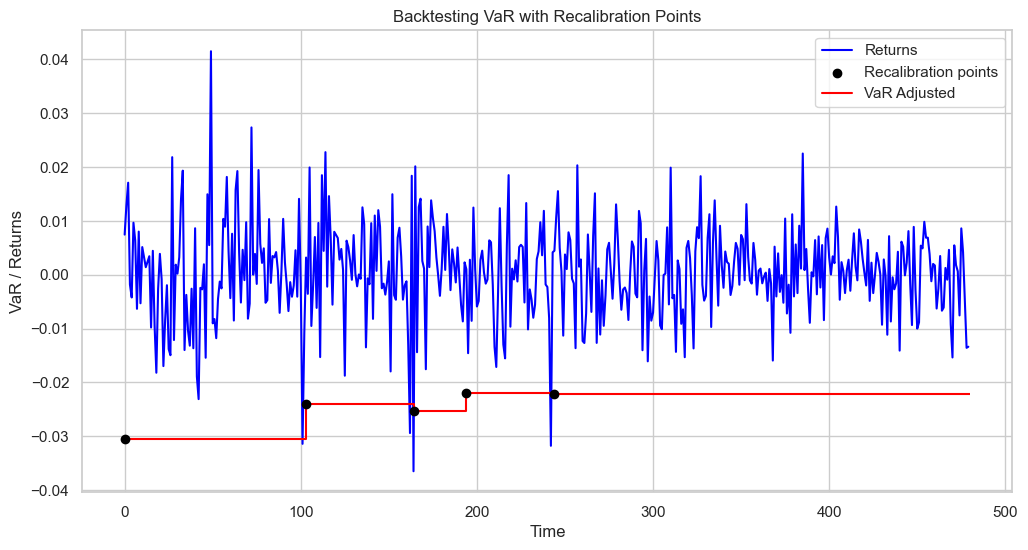

In [33]:
def iterative_backtest(data_train, data_test, var_model, alpha):
    """ Runs an iterative backtest with recalibration """
    data_train = data_train.copy()
    data_test = data_test.copy()

    var_result = - var_model(data_train, alpha=alpha, lambd=lambd)
    var_to_test = var_result[0] if isinstance(var_result, (list, tuple)) else var_result

    recalibration_points = [0]
    vars_stored = [var_to_test]

    while len(data_test) > 0 and len(data_test) >= 250:
        print("="*80)
        print(f"Old VaR to test: {var_to_test:.4%}")

        # Run daily backtest correctly
        res_backtest, index = daily_backtest(data_test, var_to_test, alpha=alpha, alpha_test=0.95, min_days=30, max_days=250)

        # Find the index of recalibration
        if res_backtest:
            print(len(data_test))
            recalibration_points.append(index)

            # Expand training data and shrink test data
            data_train = pd.concat([data_train, data_test.iloc[:index,]])
            data_test = data_test.iloc[index:,]
            var_result = - var_model(data_train, alpha=alpha, lambd=lambd)
            var_to_test = var_result[0] if isinstance(var_result, (list, tuple)) else var_result
            vars_stored.append(var_to_test)

            print(f"New VaR to test: {var_to_test:.4%}")
        else:
            print("No recalibration needed.")
            break

    return recalibration_points, vars_stored

# Execute iterative backtest
if __name__ == "__main__":
  df = telecharger_donnees("^FCHI", "1992-01-01")
  df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")
  alpha = 0.99
  lambd = 0.95
  recalibration_points, vars_stored = iterative_backtest(df_train['log_returns'], df_test['log_returns'], VaR_Gauss_EWMA, alpha=alpha)

  plt.figure(figsize=(12, 6))
  df_test['log_returns'].reset_index(drop=True, inplace=True)
  plt.plot(df_test['log_returns'], label="Returns", color='blue')
  recab = np.cumsum(np.array(recalibration_points))
  vars_stored_neg = np.array(vars_stored)

  plt.scatter(recab, vars_stored_neg, color='black', label="Recalibration points", zorder=3)
  if len(recab) > 0:
    plt.step(recab, vars_stored_neg, where='post', color='red', linestyle='solid', label="VaR Adjusted")
    plt.hlines(vars_stored_neg[-1], xmin=recab[-1], xmax=len(df_test['log_returns']), color='red', linestyle='solid')

  plt.xlabel("Time")
  plt.ylabel("VaR / Returns")
  plt.title("Backtesting VaR with Recalibration Points")
  plt.legend()
  plt.grid(True)

  plt.show()

# 6.VaR TVE : Approche Maxima par bloc

**Attention : la TVE s’intéresse aux queues de distribution droites (maximum, excès par valeurs supérieures). Penser à convertir les données avant de débuter.** \\
On pourra utiliser pour les VaR TVE les lois genextreme, gumbel_r et genpareto du package scipy.stats et les méthodes fit, pdf, ppf.

## Question a
Déterminer une taille de bloc s et construire un échantillon de maxima sur la base d’apprentissage.

---

En finance, nous regroupons généralement les données par année ou par trimestre pour étudier les valeurs extrêmes.
Néanmoins, la période d'apprentissage étant peu étendue, nous considérerons ici un maximum par mois.

In [34]:

def compute_block_maxima(df, freq='M'):
    """
    Calcule les maxima par bloc temporel sur les rendements logarithmiques négatifs.

    Args:
        df (pd.DataFrame): DataFrame contenant une colonne 'log_returns' et un index de dates.
        freq (str): Fréquence des blocs temporels (par défaut 'M' pour mois).

    Returns:
        pd.Series: Série des maxima par bloc temporel, avec les dates réelles des maxima.
    """
    # Créer une copie explicite pour éviter les warnings
    df_copy = df.copy()

    # Transformer en opposé pour inverser la queue de distribution
    df_copy['neg_log_returns'] = -df_copy['log_returns']

    # Définir des blocs temporels
    df_copy['block'] = df_copy.index.to_period(freq)

    # Trouver l'index (date réelle) du maximum dans chaque bloc
    block_maxima_dates = df_copy.groupby('block')['neg_log_returns'].idxmax()

    # Extraire les valeurs des maxima en utilisant les dates réelles
    block_maxima = df_copy.loc[block_maxima_dates, 'neg_log_returns']

    return block_maxima

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calculer les maxima par bloc
    block_maxima = compute_block_maxima(df_train)


if __name__ == "__main__":
    main()


Nous affichons cette nouvelle série sur un graphique :

In [35]:

def plot_block_maxima(df, block_maxima):
    """
    Affiche un graphique des log-returns négatifs avec les block maxima.

    Args:
        df (pd.DataFrame): DataFrame contenant les log-returns.
        block_maxima (pd.Series): Série des maxima par bloc temporel.

    Returns:
        go.Figure: Un graphique Plotly.
    """
    fig = go.Figure()

    # Tracer la série des log-returns négatifs (en gris pour le contexte)
    fig.add_trace(go.Scatter(
        x=df.index, y=-df['log_returns'], mode='lines', name='Log-returns inversés', line=dict(color='lightgray', width=1)
    ))

    # Tracer les block maxima en points rouges
    fig.add_trace(go.Scatter(
        x=block_maxima.index, y=block_maxima, mode='markers', name='Block Maxima (pertes extrêmes)', marker=dict(color='red', size=8)
    ))

    # Ajouter titres et légendes
    fig.update_layout(
        title="Block Maxima des log-returns inversés",
        xaxis_title="Temps",
        yaxis_title="Pertes",
        legend=dict(x=0.02, y=0.98),
        xaxis=dict(showgrid=True),  # Activer la grille pour l'axe X
        yaxis=dict(showgrid=True)   # Activer la grille pour l'axe Y
    )

    return fig

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calculer les maxima par bloc
    block_maxima = compute_block_maxima(df_train,"M")

    # Créer le graphique avec la nouvelle fonction
    fig = plot_block_maxima(df_train, block_maxima)

    # Afficher le graphique avec plotly
    fig.show()

if __name__ == "__main__":
    main()

## Question b
Tracer le Gumbel plot pour juger de l’hypothèse ξ=0 (i.e. GEV vs EV)

---

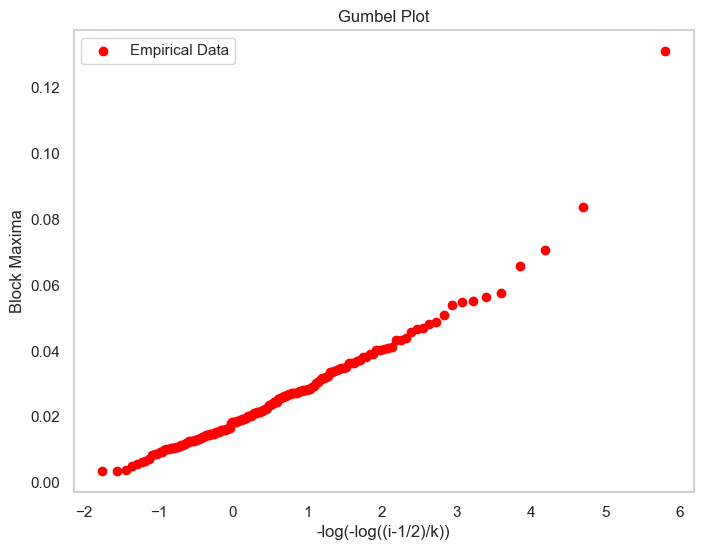

In [36]:
def plot_gumbel(block_maxima):
    """
    Trace le Gumbel Plot pour visualiser l'ajustement aux distributions extrêmes.

    Args:
        block_maxima (pd.Series): Série des maxima par bloc temporel.
    """
    block_maxima = block_maxima.sort_values()
    k = len(block_maxima)

    # Calcul des coordonnées du Gumbel plot
    x_values = -np.log(-np.log((np.arange(1, k + 1) - 0.5) / k))
    y_values = block_maxima.values

    # Tracé du Gumbel plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, color="red", label="Empirical Data")
    plt.xlabel("-log(-log((i-1/2)/k))")
    plt.ylabel("Block Maxima")
    plt.title("Gumbel Plot")
    plt.legend()
    plt.grid()
    plt.show()

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calculer les maxima par bloc
    block_maxima = compute_block_maxima(df_train)

    # Afficher le Gumbel plot
    plot_gumbel(block_maxima)

if __name__ == "__main__":
    main()

Pour avoir une idée de la distribution GEV de la serie des pertes maximales de rendements du CAC 40 pour $s=21$, nous utilisons un Gumbel plot qui est un outil graphique pour juger de l’hypothèse $\xi=0$, i.e. la distribution GEV se réduit à la distribution de Gumbel.

Pour le construire, nous devons suivre les étapes suivantes :

1. calculer l'abscisse avec la série des maximas ordonées $R_{(1)} \leq R_{(2)} \leq \ldots \leq R_{(n)}$.
2. calculer l'ordonnée de la manière suivante :

$$
- log(-log(\frac{i - 0.5}{k})), \quad i = 1, \ldots, k.
$$

Lorsque la distribution adaptée est celle de Gumbel alors le Gumbel plot est linéaire.

Les points ne forment pas une droite claire. Nous aurons tendance à considérer que le paramètre de forme ξ est différent de 0 i.e. nous ajusterons une GEV.

---


Pour accorder plus de poids à cette observation, nous avons calculé un intervalle de confiance profilé à 95% pour le paramètre de forme $\xi$. Pour ce faire, nous avons suivi les étapes suivantes :
1. Estimation des paramètres par maximum de vraisemblance : Nous avons estimé $\hat{\xi}$, $\hat{\mu}$ et $\hat{\sigma}$ en maximisant la log-vraisemblance de la loi GEV.

2. Construction du profil de vraisemblance : Nous avons fixé $\xi$ à différentes valeurs autour de $\hat{\xi}$ et, pour chacune, réestimé $\mu$ et $\sigma$ afin d'obtenir une log-vraisemblance profilée.

3. Seuil basé sur le test du rapport de vraisemblance : Le seuil critique est déterminé par la statistique $ \chi^2(1) $ :  
$$
\mathcal{L}_{\max} - \frac{\chi^2_{0.95, 1}}{2}
$$

4. Détermination des bornes de l’IC : L’intervalle est formé par les valeurs de $\xi$ pour lesquelles la log-vraisemblance reste au-dessus de ce seuil.

Cette approche permet une meilleure prise en compte de l'incertitude en évitant les approximations asymptotiques classiques.
La modélisation des maxima des pertes de rendements du CAC 40 par une distribution de Weibull serait plus adaptée.

Nous obtenons ainsi un intervalle de confiance à 95% pour le paramètre de forme $\xi$ de $[-0.257, -0.044]$. Comme 0 n'appartient pas à cet intervalle, nous pouvons rejeter l'hypothèse $\xi=0$. De ce fait, la distribution de Weibull est plus adaptée pour modéliser les maxima des pertes de rendements du CAC 40 car $\xi$ est négatif.

IC profilé pour shape: [-0.257, -0.044]


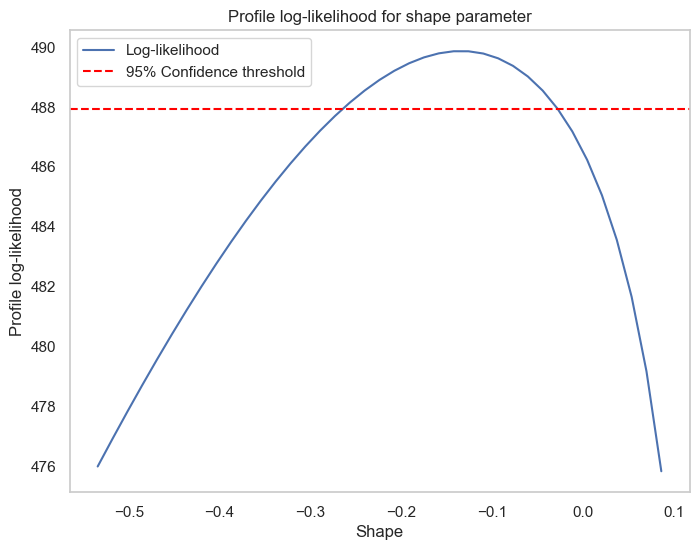

In [37]:
# Fonction de log-vraisemblance négative pour la GEV
def gev_neg_log_likelihood(params, shape_fixed, data):
    """
    Calcule la log-vraisemblance négative de la distribution GEV
    en fixant le paramètre 'shape'.

    Args:
        params (list): [loc, scale] - Paramètres de localisation et d'échelle.
        shape_fixed (float): Paramètre de forme fixé.
        data (np.array): Données des maxima par bloc.

    Returns:
        float: Log-vraisemblance négative.
    """
    loc, scale = params
    if scale <= 0:  # Contrainte pour éviter des valeurs invalides
        return np.inf
    return -np.sum(gev.logpdf(data, shape_fixed, loc=loc, scale=scale))

# Fonction pour calculer les IC profilés pour le paramètre shape
def compute_profile_likelihood(extremes, loc, scale, shape):
    """
    Calcule les intervalles de confiance profilés pour le paramètre 'shape'.

    Args:
        extremes (np.array): Données des maxima par bloc.
        loc (float): Paramètre de localisation estimé.
        scale (float): Paramètre d'échelle estimé.
        shape (float): Paramètre de forme estimé.

    Returns:
        shape_grid (np.array): Grille des valeurs de shape testées.
        profile_likelihood (np.array): Log-vraisemblance profilée.
        chi2_threshold (float): Seuil de confiance à 95%.
    """
    # Log-vraisemblance maximale
    log_likelihood_max = -gev_neg_log_likelihood([loc, scale], shape, extremes)

    # Calcul des IC profilés pour le paramètre shape
    shape_grid = np.linspace(shape - 0.4, shape + 0.4, 50)  # Plage autour de la valeur estimée
    profile_likelihood = []

    for s in shape_grid:
        # Réoptimiser loc et scale en fixant shape
        result = minimize(
            gev_neg_log_likelihood,
            x0=[loc, scale],  # Initial guess for loc and scale
            args=(s, extremes),  # Fixer 'shape' à la valeur actuelle
            bounds=[(None, None), (1e-5, None)],  # Contraintes sur loc et scale
            method='L-BFGS-B'
        )
        if result.success:
            profile_likelihood.append(-result.fun)
        else:
            profile_likelihood.append(np.nan)

    # Calcul du seuil pour les IC
    chi2_threshold = log_likelihood_max - chi2.ppf(0.95, 1) / 2

    return shape_grid, np.array(profile_likelihood), chi2_threshold

# Fonction pour tracer le profil de log-vraisemblance
def plot_profile_likelihood(shape_grid, profile_likelihood, chi2_threshold):
    """
    Trace le profil de log-vraisemblance pour le paramètre 'shape'.

    Args:
        shape_grid (np.array): Grille des valeurs de shape testées.
        profile_likelihood (np.array): Log-vraisemblance profilée.
        chi2_threshold (float): Seuil de confiance à 95%.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(shape_grid, profile_likelihood, label="Log-likelihood")
    plt.axhline(chi2_threshold, color='red', linestyle='--', label="95% Confidence threshold")
    plt.xlabel("Shape")
    plt.ylabel("Profile log-likelihood")
    plt.title("Profile log-likelihood for shape parameter")
    plt.legend()
    plt.grid()
    plt.show()

def main():

    df = telecharger_donnees("^FCHI", "1992-01-01")
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calculer les maxima par bloc
    extremes = compute_block_maxima(df_train)

    # Estimation initiale des paramètres GEV
    shape, loc, scale = gev.fit(extremes)

    # Calcul des IC profilés pour le paramètre shape
    shape_grid, profile_likelihood, chi2_threshold = compute_profile_likelihood(extremes, loc, scale, shape)

    # Déterminer les bornes des IC
    valid_points = np.where(profile_likelihood >= chi2_threshold)[0]
    if len(valid_points) > 0:
        lower_bound = shape_grid[valid_points[0]]
        upper_bound = shape_grid[valid_points[-1]]
        print(f"IC profilé pour shape: [{lower_bound:.3f}, {upper_bound:.3f}]")
    else:
        print("Impossible de déterminer des IC profilés avec les paramètres actuels.")

    # Tracer le profil de log-vraisemblance
    plot_profile_likelihood(shape_grid, profile_likelihood, chi2_threshold)

if __name__ == "__main__":
    main()

## Question c
Estimer les paramètres de loi GEV (ou EV si pertinent)

---


In [38]:
# On utilise la loi GEV car la droite du Gumbel plot n'est pas forcément linéaire,
# ce qui suggère que ξ ≠ 0 et donc qu'une loi EV (Gumbel) simple n'est pas appropriée.

def fit_gev(block_maxima):
    """
    Ajuste la loi GEV aux block maxima et affiche les paramètres estimés.

    Args:
        block_maxima (pd.Series): Série des maxima par bloc temporel.

    Returns:
        tuple: Paramètres estimés (shape c, location loc, scale scale).
    """
    params_gev = gev.fit(block_maxima)
    c, loc, scale = params_gev

    return c, loc, scale

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calculer les maxima par bloc sur df_train
    block_maxima = compute_block_maxima(df_train)

    # Ajuster la loi GEV
    c,loc,scale = fit_gev(block_maxima)
    print(f"Paramètres GEV estimés (c, loc, scale): ({c:.4f}, {loc:.4f}, {scale:.4f})")

if __name__ == "__main__":
    main()


Paramètres GEV estimés (c, loc, scale): (-0.1342, 0.0180, 0.0100)


En estimant les paramètres de la loi GEV, nous utilisons la méthode du maximum de vraisemblance. Les paramètres estimés par maximisation de la fonction de vraisemblance sont les suivants $\xi = -0.13, \mu=0.02, \sigma=0.01$. Nous constatons par ailleurs que le paramètre de forme $\xi$ est strictement négatif ce qui est cohérent avec notre observation précédente.

## Question d
Faire une validation ex-ante (analyses graphiques, QQ-plot, etc.)

---

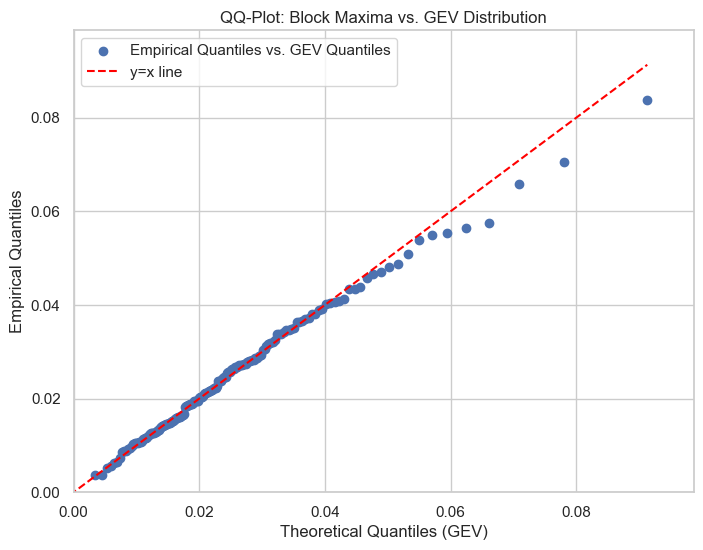

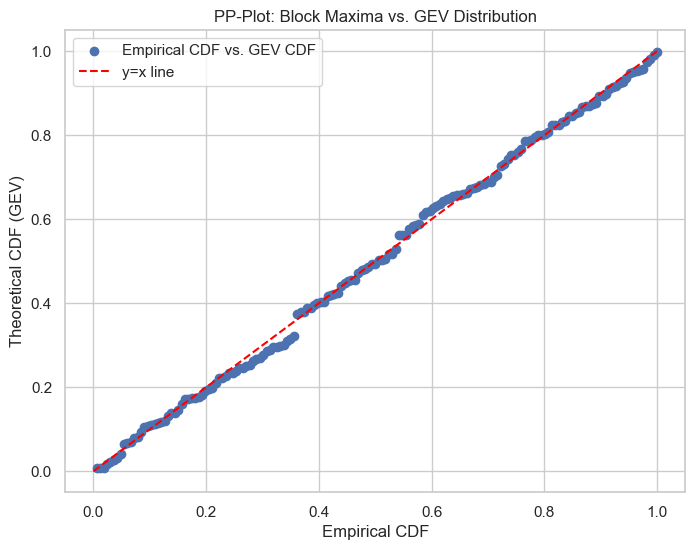

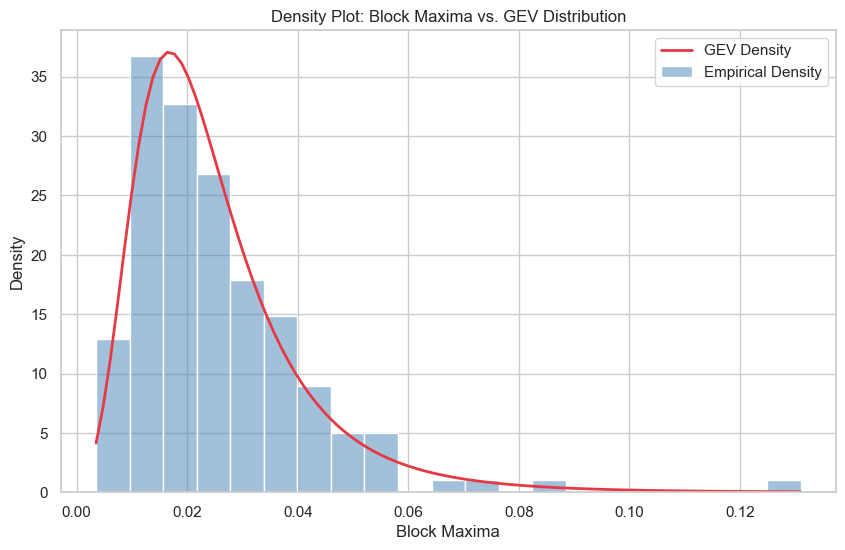

In [39]:
def plot_gev_diagnostics(block_maxima, c, loc, scale):
    """
    Génère les graphiques QQ-plot, PP-plot et densité pour comparer les block maxima à la distribution GEV.

    Args:
        block_maxima (pd.Series): Série des maxima par bloc temporel.
        c (float): Paramètre de forme de la distribution GEV.
        loc (float): Paramètre de localisation de la distribution GEV.
        scale (float): Paramètre d'échelle de la distribution GEV.
    """
    # QQ-plot
    quantiles_gev = gev.ppf(np.linspace(0, 1, len(block_maxima)), c, loc=loc, scale=scale)
    plt.figure(figsize=(8, 6))
    plt.scatter(quantiles_gev, np.sort(block_maxima), label='Empirical Quantiles vs. GEV Quantiles')
    plt.plot(quantiles_gev, quantiles_gev, color='red', linestyle='--', label='y=x line')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.xlabel('Theoretical Quantiles (GEV)')
    plt.ylabel('Empirical Quantiles')
    plt.title('QQ-Plot: Block Maxima vs. GEV Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()

    # PP-plot
    ecdf = np.arange(1, len(block_maxima) + 1) / len(block_maxima)
    cdf_gev = gev.cdf(np.sort(block_maxima), c, loc=loc, scale=scale)
    plt.figure(figsize=(8, 6))
    plt.scatter(ecdf, cdf_gev, label='Empirical CDF vs. GEV CDF')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='y=x line')
    plt.xlabel('Empirical CDF')
    plt.ylabel('Theoretical CDF (GEV)')
    plt.title('PP-Plot: Block Maxima vs. GEV Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Density plot
    x = np.linspace(min(block_maxima), max(block_maxima), 100)
    density_gev = gev.pdf(x, c, loc=loc, scale=scale)
    plt.figure(figsize=(10, 6))
    sns.histplot(block_maxima, stat='density', kde=False, label='Empirical Density', color='#4682B4', alpha=0.5)
    plt.plot(x, density_gev, color='#E63946', lw=2, label='GEV Density')
    plt.xlabel('Block Maxima')
    plt.ylabel('Density')
    plt.title('Density Plot: Block Maxima vs. GEV Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calculer les maxima par bloc sur df_train
    block_maxima = compute_block_maxima(df_train)

    # Ajuster la loi GEV
    c, loc, scale = fit_gev(block_maxima)

    # Tracer les diagnostics
    plot_gev_diagnostics(block_maxima, c, loc, scale)

if __name__ == "__main__":
    main()

Les graphiques montrent que la distribution GEV ajuste relativement bien les données centrales mais peine à capturer les queues de distribution, en particulier pour les événements extrêmes.

Sur le QQ-plot, les points s'écartent de la ligne y = x à droite, indiquant un mauvais ajustement dans la queue supérieure de la distribution.Cet écart est attendu car on modélise des extrêmes d'extrêmes (les maxima par bloc). La queue de distribution des événements extrêmes est difficile à capturer parfaitement, même avec une distribution GEV.

Au niveau du PP-plot, nous observons que les probabilités cumulées empiriques sont sensiblement les mêmes que les probabilités cumulées théoriques de la distribution GEV.

Enfin, sur la densité, nous voyons que la densité GEV semble sous-estimer la densité empiriques pour les valeurs extrêmes notamment. Cela confirme l'observation effectuée sur les QQ-plot.


## Question e
Calculer la VaR TVE par MB sur base d’apprentissage pour alpha = 99% \\
Attention :  $$ 𝜶(𝑩𝑴) =𝜶^s $$

---

In [40]:
def compute_var_tve(alpha, c, loc, scale, freq='M'):
    """
    Calcule la Value at Risk (VaR) basée sur la distribution GEV (Generalized Extreme Value).

    Args:
        alpha (float): Le niveau de confiance (par exemple, 0.99 pour un niveau de 99%).
        c (float): Paramètre de forme de la distribution GEV.
        loc (float): Paramètre de localisation de la distribution GEV.
        scale (float): Paramètre d'échelle de la distribution GEV.
        freq (str): Fréquence des blocs temporels ('M' pour mois, 'Q' pour trimestre, 'Y' pour année).

    Returns:
        float: La VaR calculée à partir de la distribution GEV.
    """
    # Définir l'exposant en fonction de la fréquence
    if freq == 'M':  # Mensuel
        exponent = 21  # ~21 jours ouvrés par mois
    elif freq == 'Q':  # Trimestriel
        exponent = 63  # ~63 jours ouvrés par trimestre (21 jours/mois * 3 mois)
    elif freq == 'Y':  # Annuel
        exponent = 252  # ~252 jours ouvrés par an (21 jours/mois * 12 mois)
    else:
        raise ValueError("Fréquence non reconnue. Utilisez 'M' (mois), 'Q' (trimestre) ou 'Y' (année).")

    # Calcul de alpha_bm en fonction de la fréquence
    alpha_bm = alpha**exponent

    # Calcul de la VaR via la fonction quantile de la distribution GEV
    var_tve = gev.ppf(alpha_bm, c=c, loc=loc, scale=scale)

    # On prend l'opposé pour revenir aux rendements initiaux
    return -var_tve


def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Découpage en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calculer les maxima par bloc sur df_train
    block_maxima = compute_block_maxima(df_train)

    # Ajuster la loi GEV
    c, loc, scale = fit_gev(block_maxima)

    # Calculer la VaR TVE
    alpha = 0.99
    var_tve = compute_var_tve(alpha, c, loc, scale)

    print(f"La VaR TVE à {alpha*100}% de confiance est : {var_tve*100:.4f}%")

if __name__ == "__main__":
    main()

La VaR TVE à 99.0% de confiance est : -3.5303%


Nous observons que la VaR en utilisant l'approche par block maxima est plus faible que certaines VaR que nous avons pu calculer dans les parties précédentes.

Cela peut s'expliquer par le fait que la distribution GEV capturent mal les extrêmes, comme nous avons pu le voir sur le QQ-plot ou sur le density plot.

# 7.VaR TVE : Approche Peak over threshold

## Question a
Ecrire une fonction permettant d’obtenir le mean excess plot

---

Le Mean Excess Plot (ou graphique des excès moyens) est un outil visuel utilisé pour identifier la distribution des queues d'une série de données, en particulier pour détecter la présence de queues lourdes. Il est souvent utilisé dans l'analyse des extrêmes pour déterminer si une distribution suit une loi de type Pareto (queue lourde) ou une loi à queue légère.

Pour un seuil u, l'excès moyen est calculé comme la moyenne des dépassements par rapport à ce seuil :

$$
e(u) = \mathbb{E}[X - u \mid X > u]
$$

où :
* X est la variable aléatoire représentant les données,
* u est le seuil

In [41]:
def mean_excess_plot(data, threshold_values):
    """
    Generates a mean excess plot for a given dataset and range of thresholds.

    Args:
        data: A 1D numpy array or pandas Series of data values.
        threshold_values: A 1D numpy array or list of threshold values.

    Returns:
        A tuple containing two lists: mean excesses and the corresponding threshold values.
    """

    mean_excesses = []
    for threshold in threshold_values:
        exceedances = data[data > threshold] - threshold
        if exceedances.size > 0 :
          mean_excess = exceedances.mean()
        else:
          mean_excess = np.nan  # Handle cases with no exceedances
        mean_excesses.append(mean_excess)

    return mean_excesses, threshold_values

## Question b
Déterminer u par analyse graphique. \\
*Attention : ne pas considérer ni les valeurs négatives de u, ni les valeurs trop extrêmes, au risque d’écraser l’échelle visuelle du graphique.*

---

Nous affichons dans un premier temps le Mean Excess Plot sans troncature des données, i.e. en considérant toutes les valeurs, jusqu'à la valeur maximale de notre dataframe. Nous observons que le comportement est erratique, et qu'aucune identification de seuil n'est possible.

Nous affichons ensuite un deuxième graphique, qui cette fois-ci n'affiche que les données situées sous le 95ème quantile de l'opposé des log-rendements. Le seuil à choisir est maintenant plus identifiable. Nous l'avons fixé à **0.012**, car nous observons une tendance linéaire à partir de ce seuil.

Mean Excess Plot sans troncature des données


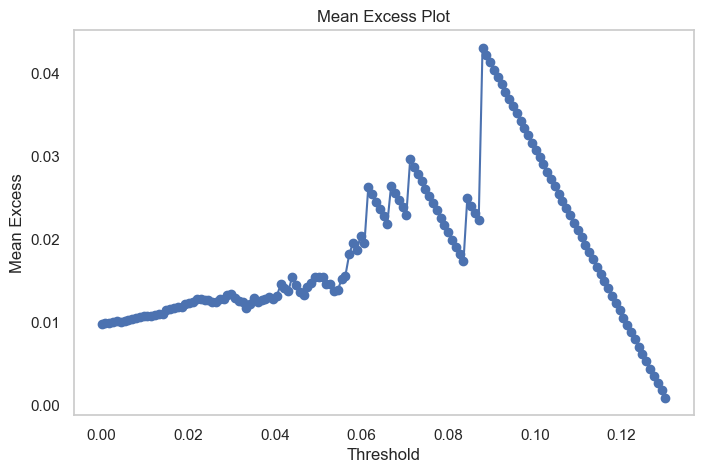

Mean Excess Plot avec troncature des données


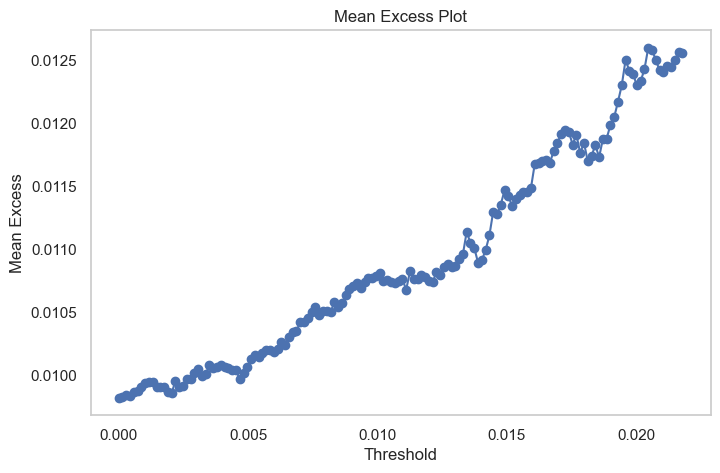

In [42]:
def plot_mean_excess(df, quantile_plot):
    """
    Calcule et trace le Mean Excess Plot pour les rendements négatifs.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les rendements.
        quantile_plot (float) : quantile à partir duquel nous tronquons les données pour l'affichage du graphique

    Affiche:
        Un graphique du Mean Excess Plot pour les rendements négatifs.
    """
    # Créer une copie du DataFrame et inverser les rendements négatifs
    df_copy = df.copy()
    df_copy['neg_log_returns'] = -df_copy['log_returns']  # Inverser les rendements

    quantile_percent = df_copy['neg_log_returns'].quantile(quantile_plot)

    # Définir un ensemble de valeurs seuils
    threshold_values = np.linspace(max(df_copy['neg_log_returns'].min(), 0), min(quantile_percent, df_copy['neg_log_returns'].max()), 150)

    # Calculer les excès moyens
    mean_excesses, thresholds = mean_excess_plot(df_copy['neg_log_returns'], threshold_values)

    # Tracer le Mean Excess Plot
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, mean_excesses, marker='o', linestyle='-')
    plt.xlabel('Threshold')
    plt.ylabel('Mean Excess')
    plt.title('Mean Excess Plot')
    plt.grid()
    plt.show()

def main():
    # Charger les données (exemple, à adapter selon tes données)
    df = telecharger_donnees("^FCHI", "1992-01-01")

    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    print("Mean Excess Plot sans troncature des données")
    quantile_plot = 1
    plot_mean_excess(df_train, quantile_plot)

    print("Mean Excess Plot avec troncature des données")
    quantile_plot = 0.95
    plot_mean_excess(df_train, quantile_plot)

if __name__ == "__main__":
    main()

## Question c
Estimer les paramètres de loi GPD

---

In [43]:


def fit_gpd_to_exceedances(df, threshold):
    """
    Ajuste la distribution de Pareto généralisée (GPD) sur les excès au-dessus du seuil spécifié.

    Args:
        df (pd.DataFrame): DataFrame contenant les rendements log.
        threshold (float): Le seuil au-dessus duquel on calcule les excès.

    Returns:
        tuple: Les paramètres estimés de la GPD (c, loc, scale).
    """
    # Filtrer les excès au-dessus du seuil
    exceedances = df['neg_log_returns'][df['neg_log_returns'] > threshold] - threshold

    # Ajuster la distribution de Pareto généralisée (GPD) sur les excès
    params_gpd = genpareto.fit(exceedances)

    # Extraire les paramètres ajustés
    c, loc, scale = params_gpd

    return c, loc, scale

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    df['neg_log_returns'] = -df['log_returns']

    # Découper les données en train/test (exemple, à adapter selon tes besoins)
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Définir le seuil (u) pour l'ajustement GPD
    threshold = 0.012

    # Appeler la fonction pour ajuster la GPD sur les excès
    c, loc, scale = fit_gpd_to_exceedances(df_train, threshold)

    print(f"Les paramètres estimés de la GPD (c, loc, scale) sont : ({c:.4f}, {loc:.4f}, {scale:.4f})")

if __name__ == "__main__":
    main()


Les paramètres estimés de la GPD (c, loc, scale) sont : (0.1342, 0.0000, 0.0093)


Les paramètres estimés de la Generalized Pareto Distribution (GPD) sont :  
- Shape (c) : 0.1342
- Loc (loc) : 0
- Scale (scale) : 0.0093

Le paramètre de forme c détermine le comportement de la queue de la distribution. Ici, c = 0.1342 (positif) indique une queue légèrement lourde, ce qui suggère la présence de valeurs extrêmes.  

Le paramètre de localisation loc est 0, ce qui signifie que la distribution est centrée à l'origine.  

Le paramètre d'échelle scale est 0.0093, indiquant une dispersion modérée des données autour de la localisation.  

En résumé, la GPD ajustée suggère une distribution avec une queue légèrement lourde, centrée à l'origine, et une dispersion modérée.

## Question d
Faire une validation ex-ante (analyse graphiques, QQ-plot, etc.)

---

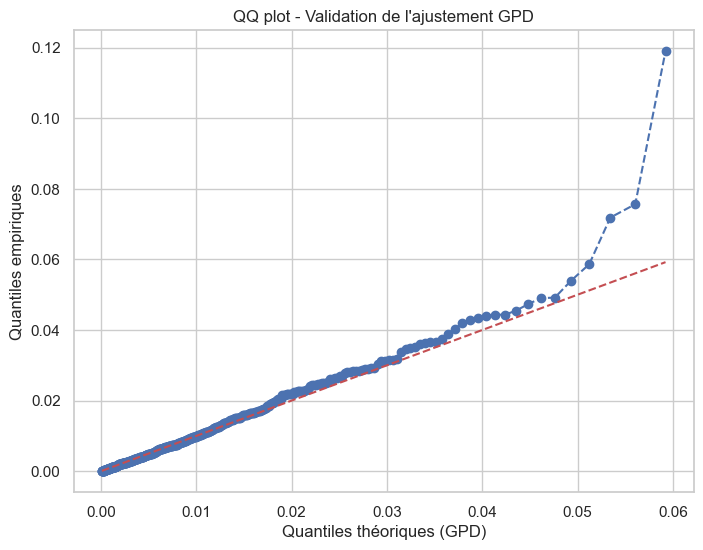

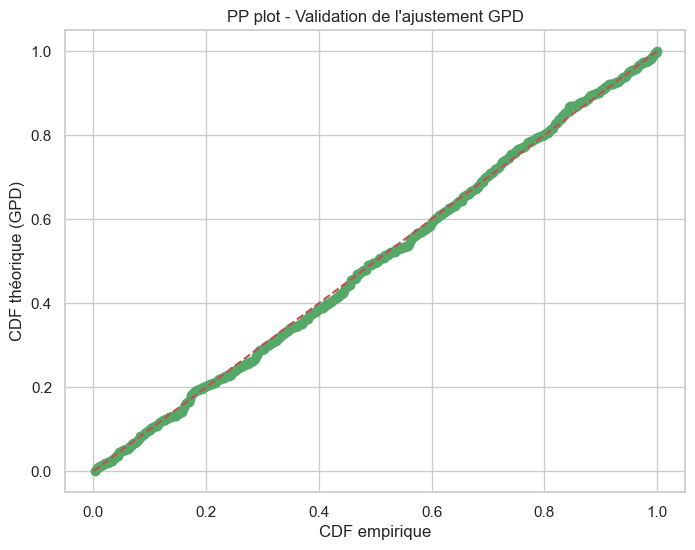

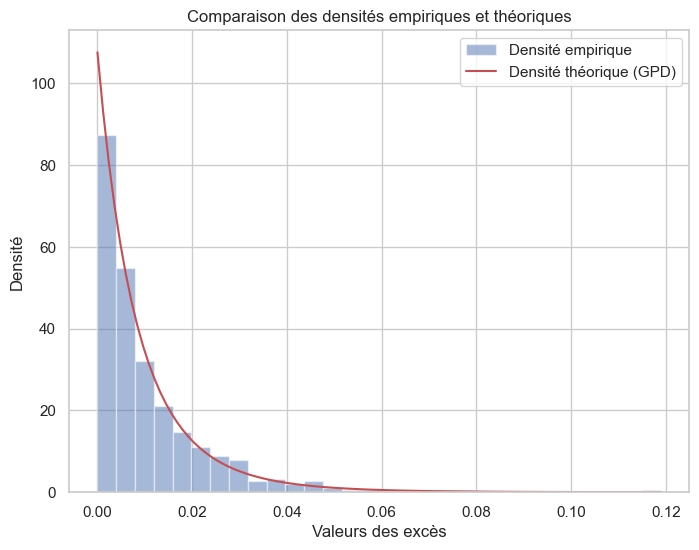

In [44]:

def plot_gpd_diagnostics(exceedances, c, loc, scale):
    """
    Génère des graphiques pour valider l'ajustement GPD.

    Args:
        exceedances (pd.Series ou np.array): Les excès au-dessus du seuil.
        c (float): Paramètre de forme de la GPD.
        loc (float): Paramètre de localisation de la GPD.
        scale (float): Paramètre d'échelle de la GPD.
    """
    # 1. QQ plot (Quantile-Quantile Plot)
    theoretical_quantiles = genpareto.ppf(np.linspace(0.01, 0.99, len(exceedances)), c, loc, scale)
    empirical_quantiles = np.sort(exceedances)

    plt.figure(figsize=(8, 6))
    plt.plot(theoretical_quantiles, empirical_quantiles, marker='o', linestyle='--', color='b')
    plt.plot([min(theoretical_quantiles), max(theoretical_quantiles)], [min(theoretical_quantiles), max(theoretical_quantiles)], 'r--')
    plt.xlabel("Quantiles théoriques (GPD)")
    plt.ylabel("Quantiles empiriques")
    plt.title("QQ plot - Validation de l'ajustement GPD")
    plt.grid(True)
    plt.show()

    # 2. PP plot (Probability-Probability Plot)
    empirical_cdf = np.arange(1, len(exceedances) + 1) / len(exceedances)
    theoretical_cdf = genpareto.cdf(np.sort(exceedances), c, loc, scale)

    plt.figure(figsize=(8, 6))
    plt.plot(empirical_cdf, theoretical_cdf, marker='o', linestyle='--', color='g')
    plt.plot([0, 1], [0, 1], 'r--')  # Ligne d'identité
    plt.xlabel("CDF empirique")
    plt.ylabel("CDF théorique (GPD)")
    plt.title("PP plot - Validation de l'ajustement GPD")
    plt.grid(True)
    plt.show()

    # 3. Comparaison des densités empiriques et théoriques
    plt.figure(figsize=(8, 6))
    plt.hist(exceedances, bins=30, density=True, alpha=0.5, label="Densité empirique")

    x_vals = np.linspace(min(exceedances), max(exceedances), 100)
    pdf_theoretical = genpareto.pdf(x_vals, c, loc, scale)
    plt.plot(x_vals, pdf_theoretical, 'r-', label="Densité théorique (GPD)")

    plt.xlabel("Valeurs des excès")
    plt.ylabel("Densité")
    plt.title("Comparaison des densités empiriques et théoriques")
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Transformer les rendements log en rendements négatifs
    df['neg_log_returns'] = -df['log_returns']

    # Découper les données en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Définir le seuil (u) pour l'ajustement GPD
    threshold = 0.012

    # Calculer les excès
    exceedances = df_train['neg_log_returns'][df_train['neg_log_returns'] > threshold] - threshold

    # Ajuster la GPD sur les excès
    c, loc, scale = fit_gpd_to_exceedances(df_train, threshold)

    # Appeler la fonction pour afficher les graphiques de validation
    plot_gpd_diagnostics(exceedances, c, loc, scale)

if __name__ == "__main__":
    main()


La GPD capture une partie de la distribution des excès; néanmoins, elle montre des limites pour modéliser parfaitement les valeurs extrêmes, en particulier dans la queue de distribution. Nous pouvons notamment le voir sur le QQ-plot.

Il est à noter que la densité de la GPD semble tout de même bien s'ajuster aux données, et également aux extrêmes.

## Question e
Calculer la VaR TVE par PoT sur base d’apprentissage pour alpha = 99%.

---

Nous faisons d'abord le redressement du niveau de quantile :
$$ 1 - α_{POT} = \frac{n}{N_u} * (1 - α) $$
avec $N_u$ le nombre d'observations au dessus du seuil

In [45]:
def calculate_alpha_pot(df_train, exceedances, alpha):
    """
    Calcule l'alpha ajusté (alpha_pot) pour une distribution d'excès.

    Args:
        df_train (pd.DataFrame): DataFrame d'entraînement contenant les rendements négatifs.
        exceedances (pd.Series ou np.array): Les excès au-dessus du seuil.
        alpha (float): Le niveau de confiance pour la VaR (Value at Risk).

    Returns:
        float: La valeur ajustée alpha_pot.
    """
    # Calcul de alpha_pot
    alpha_pot = 1 - (len(df_train['neg_log_returns'])) / len(exceedances) * (1 - alpha)
    return alpha_pot

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Transformer les rendements log en rendements négatifs
    df['neg_log_returns'] = -df['log_returns']

    # Découper les données en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Calculer les excès (pour cet exemple, on suppose un seuil de 0.012)
    threshold = 0.012
    exceedances = df_train['neg_log_returns'][df_train['neg_log_returns'] > threshold] - threshold

    # Définir le niveau de confiance
    alpha = 0.99

    # Appeler la fonction pour calculer alpha_pot
    alpha_pot = calculate_alpha_pot(df_train, exceedances, alpha)

    print(f"La valeur ajustée alpha_pot est : {alpha_pot:.4f}")

if __name__ == "__main__":
    main()


La valeur ajustée alpha_pot est : 0.9265


Nous calculons ensuite la VaR à l'aide de cette formule:
$$ VaR_h(α) = - H_{\hat{σ}, \hat{ξ}}^{-1} (α_{POT}) - u  $$

In [46]:
def calculate_var_tve_pot(alpha_pot, c, loc, scale, u):
    """
    Calcule la VaR TVE par PoT (Peak over Threshold) pour une distribution GPD ajustée.

    Args:
        alpha_pot (float): Le niveau de confiance ajusté (alpha_pot).
        c (float): Paramètre de forme de la distribution GPD.
        loc (float): Paramètre de localisation de la distribution GPD.
        scale (float): Paramètre d'échelle de la distribution GPD.
        u (float): Le seuil au-dessus duquel on calcule les excès.

    Returns:
        float: La VaR TVE par PoT calculée.
    """
    # Calcul de la VaR TVE par PoT
    var_tve_pot = -genpareto.ppf(alpha_pot, c, loc, scale) - u
    return var_tve_pot

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Transformer les rendements log en rendements négatifs
    df['neg_log_returns'] = -df['log_returns']

    # Découper les données en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Définir le seuil (u) pour l'ajustement GPD
    threshold = 0.012

    # Calculer les excès (au-dessus du seuil)
    exceedances = df_train['neg_log_returns'][df_train['neg_log_returns'] > threshold] - threshold

    # Calculer alpha_pot
    alpha = 0.99
    alpha_pot = calculate_alpha_pot(df_train, exceedances, alpha)

    # Ajuster la GPD sur les excès pour obtenir les paramètres (c, loc, scale)
    c, loc, scale = fit_gpd_to_exceedances(df_train, threshold)

    # Calculer la VaR TVE par PoT
    var_tve_pot = calculate_var_tve_pot(alpha_pot, c, loc, scale, threshold)

    print(f"La VaR TVE par PoT à {alpha*100}% de confiance est : {var_tve_pot*100:.4f}%")

if __name__ == "__main__":
    main()



La VaR TVE par PoT à 99.0% de confiance est : -4.1047%


La VaR PoT est plus faible que celle calculée avec la méthode PoT. Cela est rassurant, et vient probablement du fait que la densité de la GPD semble mieux capturer les extrêmes que la densité de la GEV sur les maxima.

## Question f
Proposer un protocole permettant de calibrer u de manière automatique, et le mettre en œuvre

---

$\underline{Contexte}$ : \\
Le seuil u dans l'analyse des extrêmes est crucial pour déterminer à partir de quel point les données suivent une GPD. Traditionnellement, \u est choisi graphiquement en identifiant le point où le Mean Excess Plot devient linéaire. Cependant, cette méthode manuelle peut être subjective et peu reproductible. Nous proposons ici un protocole automatisé pour déterminer u.

Pour ce faire, nous proposons le $\underline{protocole}$ suivant :
1. Préparation des données :
   - Tronquer les 5% des valeurs les plus extrêmes du Mean Excess Plot. Ces valeurs peuvent être erratiques et fausser l'analyse. Si la tendance linéaire est déjà observable avant cette troncature, celle-ci n'affectera pas le résultat.

2. Définition des seuils à tester :
   - Définir une plage de seuils u à tester. Cette plage doit couvrir toutes les valeurs possibles des log-rendements, de 0 à la valeur maximale (après troncature des 5% les plus extrêmes).
   - Utiliser un pas fin (par exemple, 0.001) pour garantir une précision suffisante dans la sélection du seuil.

3. Analyse de la linéarité pour chaque seuil :
   - Pour chaque seuil u dans la plage définie :
     - Calculer les excès moyens pour les valeurs supérieures à u.
     - Tracer une droite de régression linéaire entre les seuils u et les excès moyens correspondants.
     - Calculer le coefficient de détermination $R^2$ de cette régression. Ce coefficient mesure la qualité de l'ajustement linéaire. C'est d'ailleurs ce que nous cherchons à optimiser lorsque nous faisons la méthode "visuelle" (lorsque nous cherchons le seuil optimal pour obtenirla tendance linéaire optimale dans les données).

4. Sélection du seuil optimal :
   - Choisir le seuil u qui maximise le $R^2$. Un $R^2$ élevé indique que la relation entre les seuils et les excès moyens est bien représentée par une droite linéaire, ce qui valide le choix de u.

Par ailleurs, nous nous assurons de faire chaque régression sur un nombre minimal de points afin de garantir la robustesse.

In [47]:

def find_optimal_threshold(data, step=0.001, quantile_cut=0.95):
    """
    Trouve le seuil optimal u en maximisant le R² de la tendance linéaire
    du mean excess plot.

    Args:
        data (array-like): Les données (log-rendements négatifs).
        step (float): Pas d'itération pour tester différents seuils.
        quantile_cut (float): Quantile pour tronquer les valeurs extrêmes (ex: 0.95 pour supprimer 5%).

    Returns:
        float: Le seuil optimal u.
    """

    # Tronquer les valeurs extrêmes
    max_threshold = np.quantile(data, quantile_cut)
    threshold_values = np.arange(0, max_threshold, step)

    # Calculer le mean excess plot
    mean_excesses, valid_thresholds = mean_excess_plot(data, threshold_values)

    best_r2 = -np.inf
    best_u = None

    for i, u in enumerate(valid_thresholds):

        # Extraire les seuils à partir de u
        thresholds_above_u = np.array(valid_thresholds[i:])
        mean_excess_above_u = np.array(mean_excesses[i:])

        # Vérifier si assez de points pour la régression
        if len(thresholds_above_u) < 10:
            continue

        # Ajuster une régression linéaire
        X = thresholds_above_u.reshape(-1, 1)
        y = mean_excess_above_u

        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)

        if r2 > best_r2:
            best_r2 = r2
            best_u = u

    return best_u

def main():
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")

    # Transformer les rendements log en rendements négatifs
    df['neg_log_returns'] = -df['log_returns']

    # Découper les données en train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

    # Trouver le seuil optimal
    optimal_u = find_optimal_threshold(df_train['neg_log_returns'])

    print(f"Seuil optimal trouvé : {optimal_u:.4f}")

if __name__ == "__main__":
    main()

Seuil optimal trouvé : 0.0120


Nous retrouvons exactement le seuil choisi précédemment à l'aide de l'analyse visuelle. Cela pourrait confirmer que notre protocole est valide sur le jeu de données que nous considérons.

# 8. VaR GARCH 


Des méthodes de calcul de la Value at Risk traditionnelle au méthode intégrant la théorie de la valeur extrême, on considérait que la série des rendements est iid. Cependant, dans la réalité, les séries financières sont souvent caractérisées par une dépendance temporelle et une volatilité conditionnelle.  

De ce fait, il s'agira, dans cette partie, de prendre en compte la dépendance temporelle et la volatilité conditionnelle dans les séries temporelles financières. Pour ce faire, nous utiliserons un modèle de VAR dynamique avec le modèle GARCH.

Le modèle GARCH (Generalized Autoregressive Conditional Heteroskedasticity) est un modèle de volatilité conditionnelle qui permet de modéliser la volatilité des rendements financiers. Il a été introduit par Bollerslev en 1986. Le modèle GARCH est une extension du modèle ARCH (Autoregressive Conditional Heteroskedasticity) introduit par Engle en 1982. Le modèle GARCH est défini par les équations suivantes:

$$
r_t = \mu_t + \epsilon_t
$$

$$
\epsilon_t = \sigma_t z_t
$$

$$
\sigma_t^2 = \omega + \sum \alpha_i \epsilon_{t-i}^2 + \sum \beta_i \sigma_{t-i}^2
$$

Dans ce modèle $\mu_t$ est un paramètre de tendance moyenne à identifier, $\epsilon_t$ est le résidu, $\sigma_t^2$ est la variance conditionnelle, $z_t$ est un bruit blanc, $\omega$ est un paramètre de constante, $\alpha_i$ et $\beta_i$ sont les paramètres du modèle GARCH à identifier.

In [48]:
if __name__ == "__main__":
    # Charger les données
    df = telecharger_donnees("^FCHI", "1992-01-01")
    # Effectuer la division train/test
    df_train, df_test = split_train_test(df, "2008-10-15", "2022-07-26", "2022-07-27", "2024-06-11")

data_train = df_train["log_returns"].copy()
data_test = df_test["log_returns"].copy()


### 8.a. Etude de l’applicabilité d’un modèle AR[1]-GARCH[1,1]

---

Le modèle AR(1)-GARCH(1,1) est le modèle qui, en pratique, est utilisé pour réaliser la VaR dynamique. Cependant, il n'est pas tout le temps adapté aux données financières. Dans ce TP, nous allons commencer par tester l'éligibilité de ce modèle dans le cadre des données que nous possédons. 

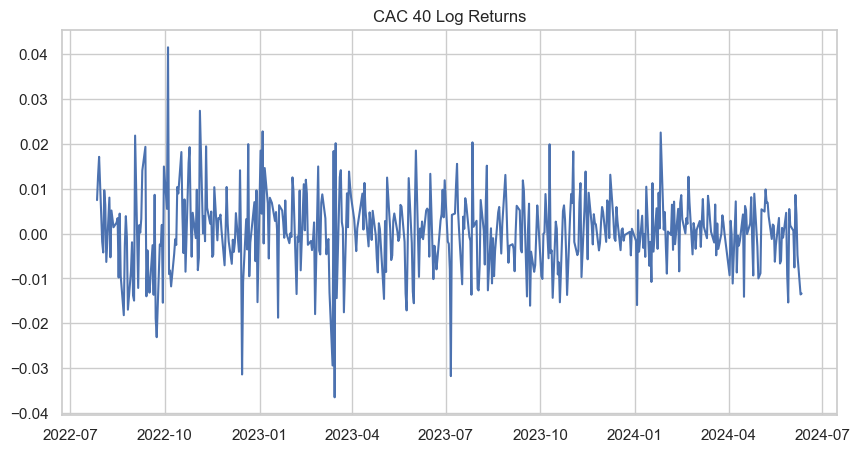

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(data_test, label='Train')
plt.title('CAC 40 Log Returns')
plt.show()

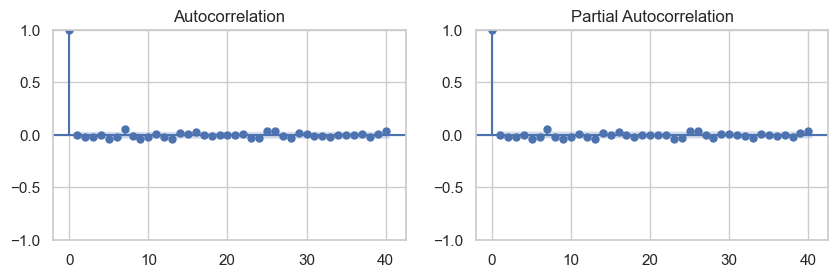

In [50]:
## ACF et PACF
plt.figure(figsize=(10, 6))
plt.subplot(221)
plot_acf(data_train, ax=plt.gca(), lags=40)
plt.subplot(222)
plot_pacf(data_train, ax=plt.gca(), lags=40)
plt.show()


Dans la série temporelle que nous possédons, nous constatons que la série peut être modéliser par un AR(1). Pour un test plus rigoureux de cette hypothèse, nous allons utiliser la méthode de Lljung Box afin de déterminer le meilleur modèle qui puisse modéliser la série. Ainsi, pour un ordre pmax = 2 et qmax=2, nous allons :
1. Estimer les paramètres du modèle ARMA(p,q) pour chaque combinaison de p et q
2. Calculer la statistique de Ljung Box pour chaque combinaison de p et q afin d'examiner si les résidus d'un modèle sont du bruit blanc 
3. Filtrer les modèles pour lesquels les résidus sont du bruit blanc 
4. Choisir le meilleur modèle en utilisant le critère d'Akaike

In [51]:

# Paramètres du modèle
p_max = 2
q_max = 2
best_aic = np.inf
best_order = (0, 0, 0)

# Chargement de la série temporelle
np.random.seed(42)
data_unindex = data_train.copy()
data_unindex.reset_index(drop=True, inplace=True)

# Création de la matrice pour stocker les AIC
aic_matrix = pd.DataFrame(np.nan, index=[f"p={p}" for p in range(p_max+1)], 
                          columns=[f"q={q}" for q in range(q_max+1)])

bb_test = pd.DataFrame(0, index=[f"p={p}" for p in range(p_max+1)], 
                          columns=[f"q={q}" for q in range(q_max+1)])

# Boucle pour estimer les modèles et stocker les AIC
for p in range(p_max + 1):
    for q in range(q_max + 1):
        try:
            model = ARIMA(data_unindex, order=(p, 0, q))
            out = model.fit()
            aic_matrix.loc[f"p={p}", f"q={q}"] = out.aic  # Stockage de l'AIC
            
            # Test de la blancheur des résidus
            ljung_box_result = acorr_ljungbox(out.resid, lags=[1], return_df=True)
            p_value = ljung_box_result['lb_pvalue'].iloc[0]

            if p_value > 0.05:
                bb_test.loc[f"p={p}", f"q={q}"] = 1
            
            # Mise à jour du meilleur modèle
            if out.aic < best_aic :
                best_aic = out.aic
                best_order = (p, 0, q)
                
        except Exception as e:
            print(f"Erreur avec (p={p}, q={q}): {e}")

print(f"Meilleur modèle ARIMA: {best_order} avec AIC={best_aic}")

print("="*30)
print("Matrice des AIC:")
print(aic_matrix)
print("="*30)
print("Matrice des test de Lljung box (1 lorsque résidus non autocorrélés):")
print(bb_test)

Meilleur modèle ARIMA: (0, 0, 0) avec AIC=-20100.176479566246
Matrice des AIC:
              q=0           q=1           q=2
p=0 -20100.176480 -20098.205891 -20097.679059
p=1 -20098.227385 -20099.862840 -20097.046957
p=2 -20097.887027 -20098.545030 -20094.033191
Matrice des test de Lljung box (1 lorsque résidus non autocorrélés):
     q=0  q=1  q=2
p=0    1    1    1
p=1    1    1    1
p=2    1    1    1


In [52]:
p = 1
q = 0

AR1 = ARIMA(data_unindex, order=(p, 0, q))
print(AR1.fit().summary())

                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                 3523
Model:                 ARIMA(1, 0, 0)   Log Likelihood               10052.114
Date:                Sun, 23 Mar 2025   AIC                         -20098.227
Time:                        12:13:15   BIC                         -20079.726
Sample:                             0   HQIC                        -20091.627
                               - 3523                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.621      0.535      -0.000       0.001
ar.L1         -0.0037      0.012     -0.321      0.748      -0.027       0.019
sigma2         0.0002   2.16e-06     89.947      0.0

En utilisant la méthode énoncée plus haut, nous constatons que le modèle ARMA(0,0) est le meilleur modèle. En effet, c'est le modèle avec le critère d'Akaike le plus faible. Cela porte à croire que la tendance moyenne de la série est constante. Nous allons tout de même utiliser un modèle AR(1) pour la modéliser. En effet, c'est le deuxième modèle avec un AIC faible.

Dans la série des résidus, nous constatons des clusters de volatilité ce qui est signe d'une volatilité conditionnelle, et donc de la présence d'un GARCH. De plus, dans la série des résidus du log-rendement, nous constatons une faible autocorrélation, ce qui les fait ressembler à du bruit blanc. Toutefois, lorsque l'on examine ces résidus au carré, la série temporelle présente généralement une forte autocorrélation, mise en évidence par la présence de grappes de volatilité. Cela suggère que les rendements représentent un processus hétéroscédastique, ce qui rend le modèle GARCH particulièrement pertinent dans le cadre de notre étude.

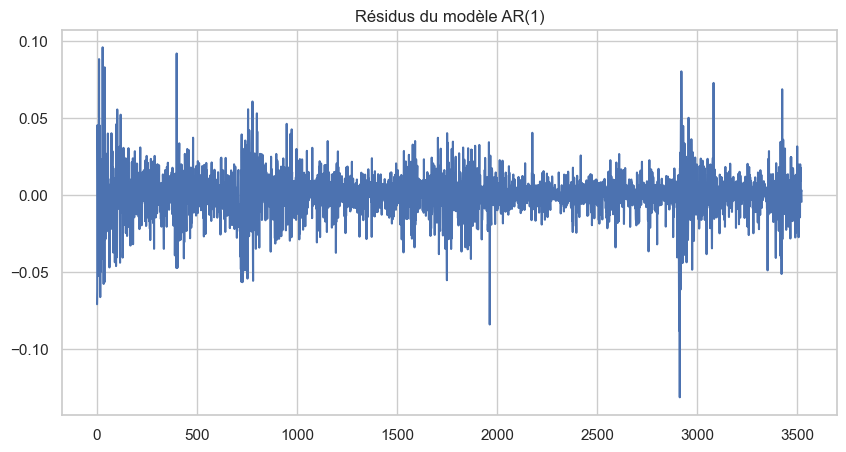

In [53]:
AR1_resid = AR1.fit().resid
plt.figure(figsize=(10, 5))
plt.plot(AR1_resid)
plt.title("Résidus du modèle AR(1)")
plt.show()

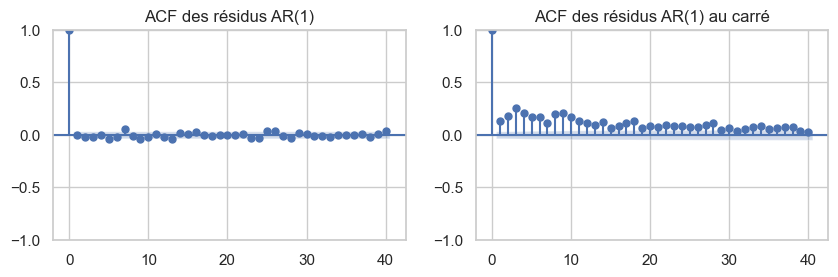

In [54]:
plt.figure(figsize=(10, 6))
plt.subplot(221)
plot_acf(AR1_resid, lags=40, ax=plt.gca())
plt.title("ACF des résidus AR(1)")
plt.subplot(222)
plot_acf(AR1_resid**2, lags=40, ax=plt.gca())
plt.title("ACF des résidus AR(1) au carré")
plt.show()

Motivés par les commentaires de (Franke, Härdle et Hafner 2004) suggérant que, dans les applications pratiques, les modèles GARCH avec des ordres plus petits décrivent souvent suffisamment les données et que dans la plupart des cas GARCH(1,1) est adéquat, nous avons considéré quatre combinaisons différentes de p=0, 1 et q=1, 2 pour chaque période afin d'entraîner le modèle GARCH, en supposant que les résidus standardisés suivent une distribution normale.

In [55]:


def find_garch(p_min, p_max, q_min, q_max, data, dist="normal"):
    """
    Trouve le meilleur modèle GARCH(p, q) en minimisant l'AIC.

    Paramètres :
    - p_min, p_max : Bornes pour p (ordre de l'AR dans la variance)
    - q_min, q_max : Bornes pour q (ordre de MA dans la variance)
    - data : Série temporelle utilisée pour l'estimation
    - dist : Distribution des erreurs ("normal", "t", "ged", etc.)

    Retour :
    - DataFrame contenant les valeurs de AIC pour chaque combinaison (p, q)
    - Meilleur modèle GARCH trouvé en fonction du critère AIC
    """
    
    best_aic = np.inf
    best_order = (0, 0, 0)
    
    results = []

    for p in range(p_min, p_max + 1):
        for q in range(q_min, q_max + 1):
            try:
                # Spécification du modèle GARCH(p, q)
                garch_spec = arch_model(data, vol='Garch', p=p, q=q, mean='zero', dist=dist)
                out = garch_spec.fit(disp="off")
                
                # Calcul de l'AIC
                current_aic = out.aic * len(data)

                # Mettre à jour le meilleur modèle si un plus petit AIC est trouvé
                if current_aic < best_aic:
                    best_aic = current_aic
                    best_order = (p, 0, q)
                
                # Ajouter les résultats dans la liste
                results.append({'p': p, 'q': q, 'aic': current_aic, 'relative_gap': np.nan})
            
            except Exception as e:
                print(f"Erreur pour (p={p}, q={q}): {e}")
                continue
    
    # Convertir en DataFrame
    results_df = pd.DataFrame(results)

    # Calculer l'écart relatif par rapport au meilleur AIC
    results_df['relative_gap'] = (results_df['aic'] - best_aic) * 100 / best_aic
    
    return results_df, best_order

results_df, best_garch_order = find_garch(p_min=1, p_max=2, q_min=0, q_max=2, data=AR1_resid, dist="normal")

print(f"Meilleur modèle GARCH: {best_garch_order} avec AIC={best_aic}")
print("="*30)
print("Résultats pour les modèles testés:")
results_df.sort_values(by='relative_gap', ascending=False)

Meilleur modèle GARCH: (1, 0, 1) avec AIC=-20100.176479566246
Résultats pour les modèles testés:


,p,q,aic,relative_gap
1,1,1,-7.495282e+07,-0.000000
4,2,1,-7.492640e+07,-0.035249
2,1,2,-7.488162e+07,-0.094992
5,2,2,-7.484512e+07,-0.143686
3,2,0,-7.283013e+07,-2.832037
0,1,0,-7.074632e+07,-5.612197


En utilisant le critère AIC pour sélectionner le meilleur modèle, nous avons conclu que GARCH(1,1) est effectivement le meilleur modèle.

### 8.b. Estimation les paramètres du modèle AR[1]-GARCH[1,1] 
---

In [56]:
AR1 = ARIMA(data_unindex, order=(1, 0, 0))
AR1_resid = AR1.fit().resid
garch11 = arch_model(AR1_resid, vol='Garch', p=1, q=1, mean='zero', dist='normal')
print("="*78)
print("Résumé du modèle GARCH(1,1)")
print("="*78)
print(garch11.fit(disp="off").summary())

Résumé du modèle GARCH(1,1)
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                10640.6
Distribution:                  Normal   AIC:                          -21275.3
Method:            Maximum Likelihood   BIC:                          -21256.8
                                        No. Observations:                 3523
Date:                Sun, Mar 23 2025   Df Residuals:                     3523
Time:                        12:13:16   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.8925e-06  1.141e-

In [57]:
cond_resid =garch11.fit(disp="off").conditional_volatility # Volatilité conditionnelle => sigma_t
resid = garch11.fit(disp="off").resid # résidus du modèle => eps_t
resid_std = garch11.fit(disp="off").std_resid  # résidus studentisés => eta_t

# jarque bera test


jb_test = jarque_bera(resid_std)
print("H0: Les résidus studentisés suivent une loi normale")
print(f"Test de Jarque-Bera sur les résidus studentisés: JB={jb_test[0]}, p-value={jb_test[1]}")
# reject the null hypothesis of normality for the distribution of the residuals, 
# as a rule of thumb, which implies that the data to be fitted is not
# normally distributed

H0: Les résidus studentisés suivent une loi normale
Test de Jarque-Bera sur les résidus studentisés: JB=850.9780785425617, p-value=1.631015672319655e-185


Le modèle AR(1)-GARCH(1,1) estimé est le suivant :

$$
r_t = \mu_t + \epsilon_t
$$

où $\mu_t = 0.0001 - 0.0037 r_{t-1}$
 
$$
\epsilon_t = \sigma_t \eta_t
$$

$$
\sigma_t^2 = 3.89 \times 10^{-6} + 0.10 \times \epsilon_{t-i}^2 + 0.88 \times \sigma_{t-i}^2
$$

avec $\eta_t$ un bruit blanc supposée gaussien.

Dans ce cas, nous rencontrons des problèmes au niveau de la significativité du coefficient AR(1). En effet, il aurait été plus judicieux de ne pas modéliser la tendance moyenne du rendement et la supposer constante. En ce qui concerne les paramètres du modèle GARCH, nous constatons que (α + β) = 0.98, ce qui est très proche de 1, ce qui suggère une volatilité persistante mais stationnaire.


### 8.c. Vérification des résidus de l’AR[1]-GARCH[1,1]
---

In [58]:
# Test d'homoscédasticité
# Ljung-Box test sur résidus
lb_test_resid = acorr_ljungbox(resid_std, lags=[i for i in range(1, 13)], return_df=True)
print("Ljung-Box Test sur résidus:\n", lb_test_resid)

# Ljung-Box test sur carrés des résidus
lb_test_resid_sq = acorr_ljungbox(resid_std**2, lags=[i for i in range(1, 13)], return_df=True)
print("Ljung-Box Test sur carrés des résidus:\n", lb_test_resid_sq)

Ljung-Box Test sur résidus:
      lb_stat  lb_pvalue
1   0.000846   0.976797
2   0.564325   0.754151
3   0.689613   0.875644
4   1.252257   0.869422
5   2.243790   0.814486
6   2.516231   0.866647
7   2.832293   0.900071
8   2.957450   0.936999
9   3.865158   0.920061
10  4.764025   0.906374
11  4.862760   0.937630
12  6.985621   0.858562
Ljung-Box Test sur carrés des résidus:
       lb_stat  lb_pvalue
1    0.236929   0.626433
2    0.297870   0.861625
3    6.739220   0.080691
4    7.481678   0.112520
5    8.164607   0.147394
6    8.302654   0.216758
7    8.813775   0.266304
8    9.474246   0.303880
9   10.047266   0.346672
10  11.646076   0.309441
11  13.473337   0.263516
12  13.893580   0.307556


In [59]:
# LM test pour les effets ARCH

lm_test = het_arch(resid_std)
print('LM Test Statistique: %.3f, p-value: %.3f' % (lm_test[0], lm_test[1]))

LM Test Statistique: 12.286, p-value: 0.266


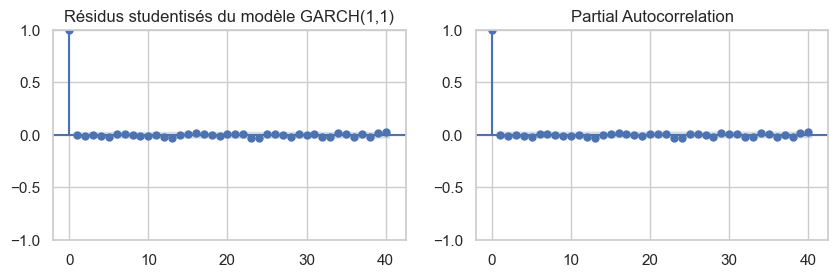

In [60]:
plt.figure(figsize=(10, 6))
plt.subplot(221)
plot_acf(resid_std, lags=40, ax=plt.gca())
plt.title("ACF des résidus studentisés")
plt.title("Résidus studentisés du modèle GARCH(1,1)")
plt.subplot(222)
plot_pacf(resid_std, lags=40, ax=plt.gca())
plt.show()

De plus, au niveau du GARCH(1,1), les résidus sont bien des bruits blancs homoscédastiques (test de lljung box et test LM). Cependant, nous avons supposé que $\eta_t$ est un bruit blanc gaussien. Cela n'est pas vérifié. Il aurait été judicieux de tester d'autres distributions telles que Students’s t (’t’, ‘studentst’), Skewed Student’s t (‘skewstudent’, ‘skewt’) ou encore Generalized Error Distribution (GED). 

<blockquote>
**Test de Lagrange Multiplier (LM) pour l'effet ARCH**

Le test de Lagrange Multiplier (LM) pour l'effet ARCH est un outil statistique qui vérifie la présence d'effets ARCH (AutoRegressive Conditional Heteroskedasticity) dans une série temporelle.

L'effet ARCH se manifeste lorsque la variance d'une erreur est une fonction de ses erreurs passées. Cette propriété est courante dans les séries temporelles financières, où de grandes variations des rendements sont souvent suivies par de grandes variations et vice versa.

Le test de LM vérifie l'hypothèse nulle que les erreurs sont homoscédastiques (variance constante). Si la p-value du test est inférieure à un seuil prédéfini (généralement 0,05), l'hypothèse nulle est rejetée, indiquant la présence d'effets ARCH.
</blockquote>


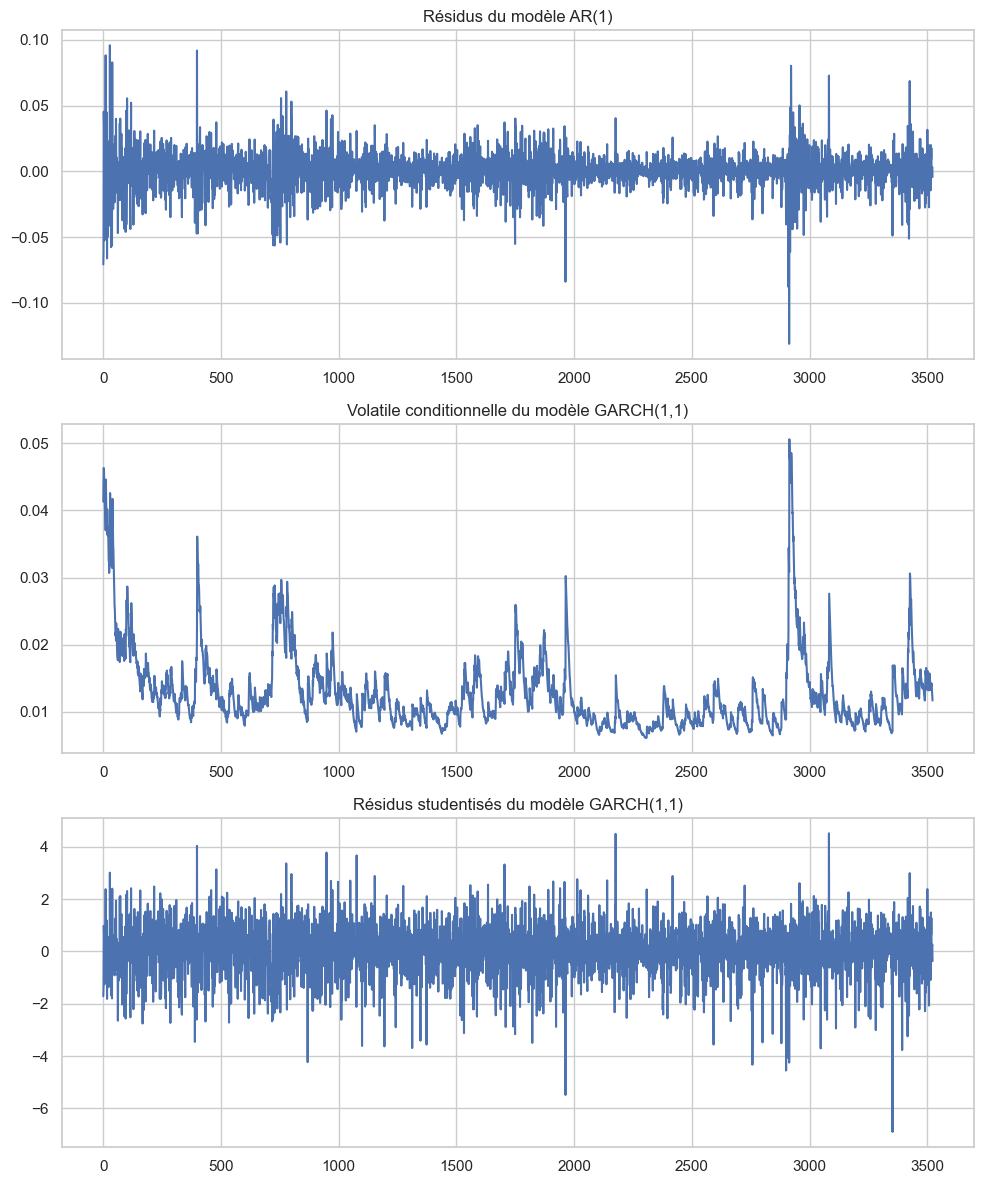

In [61]:
# Création de la figure avec des sous-graphiques alignés verticalement
plt.figure(figsize=(10, 12))

# Premier graphique : CAC 40
plt.subplot(311)
plt.plot(resid) 
plt.title("Résidus du modèle AR(1)")

# Deuxième graphique : Résidus du modèle AR(1)
plt.subplot(312)
plt.plot(cond_resid)
plt.title("Volatile conditionnelle du modèle GARCH(1,1)")

# Troisième graphique : Résidus studentisés du modèle GARCH(1,1)
plt.subplot(313)
plt.plot(resid_std, label='Résidus studentisés du modèle GARCH(1,1)')
plt.title("Résidus studentisés du modèle GARCH(1,1)")

# Affichage des graphiques
plt.tight_layout()
plt.show()


### 8.d. Dynamique historique de $\mu_t$ et $\sigma_t$

$$
r_t = \mu_t + \sigma_t \times \epsilon_t
\quad
\text{avec} \quad
\begin{cases}
    \mu_t = \mu + \varphi r_{t-1} \\
    \sigma_t^2 = \omega + a (r_{t-1} - \mu_{t-1})^2 + b \sigma_{t-1}^2
\end{cases}
$$

Pour avoir la dynamique historique de $\mu_t$ et $\sigma_t$, nous allons utiliser les données historiques de la série temporelle ainsi que les estimations des paramètres $\Theta = (\mu, \varphi, \omega, a, b)$ du modèle AR(1)-GARCH(1,1) que nous avons estimé précédemment par maximum de vraisemblance.

Pour $t=1$, nous allons initialiser $\mu_1$ par la moyenne $\hat{\mu}$ et $\sigma_1$ par la variance à long terme $\frac{\omega}{1 - a - b}$.

In [62]:
print(AR1.fit().summary())

# tester arima avec arch_model ou arch
mu = AR1.fit().params[0]
print(f"Paramètre mu: {mu}")
phi = AR1.fit().params[1]
print(f"Paramètre phi: {phi}")

                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                 3523
Model:                 ARIMA(1, 0, 0)   Log Likelihood               10052.114
Date:                Sun, 23 Mar 2025   AIC                         -20098.227
Time:                        12:13:16   BIC                         -20079.726
Sample:                             0   HQIC                        -20091.627
                               - 3523                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.621      0.535      -0.000       0.001
ar.L1         -0.0037      0.012     -0.321      0.748      -0.027       0.019
sigma2         0.0002   2.16e-06     89.947      0.0

In [63]:
print(garch11.fit(disp="off").summary())
omega = garch11.fit(disp="off").params[0]
print(f"Paramètre omega: {omega}")
a = garch11.fit(disp="off").params[1]
print(f"Paramètre alpha: {a}")
b = garch11.fit(disp="off").params[2]
print(f"Paramètre beta: {b}")

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                10640.6
Distribution:                  Normal   AIC:                          -21275.3
Method:            Maximum Likelihood   BIC:                          -21256.8
                                        No. Observations:                 3523
Date:                Sun, Mar 23 2025   Df Residuals:                     3523
Time:                        12:13:16   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.8925e-06  1.141e-11  3.411e+05      0.000 [3.

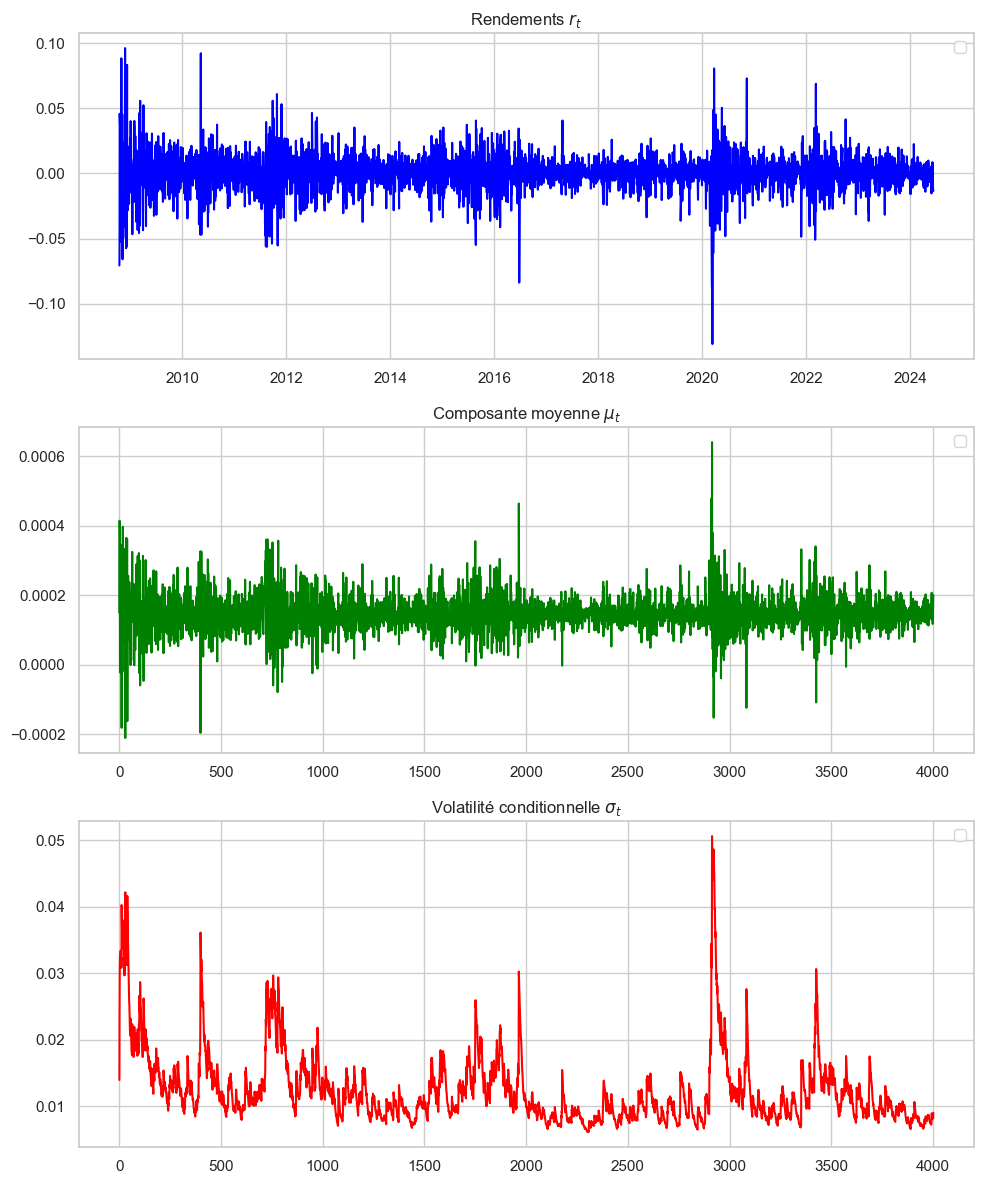

In [64]:
T_train = len(data_train)
T_test = len(data_test)

T = T_train + T_test

# Initialisation des séries
r = pd.concat([data_train, data_test], axis=0)
mu_t = np.zeros(T)    # Composante moyenne
sigma2 = np.zeros(T)  # Variance conditionnelle

# Conditions initiales
mu_t[0] = mu
sigma2[0] = omega / (1 - a - b)  # Variance de long terme

# Simulation du modèle
for t in range(1, T):
    mu_t[t] = mu + phi * r[t-1]  # Partie moyenne
    sigma2[t] = omega + a * (r[t-1] - mu_t[t-1])**2 + b * sigma2[t-1]  # Variance conditionnelle

# Affichage des résultats
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

ax[0].plot(r, color="blue")
ax[0].set_title("Rendements $r_t$")
ax[0].legend()

ax[1].plot(mu_t, color="green")
ax[1].set_title("Composante moyenne $\mu_t$")
ax[1].legend()

ax[2].plot(np.sqrt(sigma2), color="red")
ax[2].set_title("Volatilité conditionnelle $\sigma_t$")
ax[2].legend()

plt.tight_layout()
plt.show()


En analysant la dynamique de $\mu_t$, nous constatons que la tendance moyenne est très semblable à la série des log-rendements. Cela est dû au fait que le modèle AR(1) n'est pas pertinent pour modéliser la série. En effet, la série des log-rendements ressemble déjà à un bruit blanc. Par ailleurs, nous observons de fortes périodes de volatilité dans la série des log-rendements pendant les périodes de crises, i.e. 2008-2009 qui correspond à la crise des subprimes et 2020 qui correspond à la crise du Covid-19. Le modèle GARCH semble bien capturer ces périodes de volatilité dans la volatilité conditionnelle calibrée.

### 8.e. Estimation de la VaR

#### 8.e.i. Estimation de la VaR sur les résidus

Pour calibrer la VaR dynamique, il est tout d'abord necessaire de calibrer la VaR sur les résidus. En effet, la VaR sur les résidus est une étape préliminaire à la calibration de la VaR dynamique. Pour ce faire, nous allons utiliser les résidus du modèle AR(1)-GARCH(1,1) que nous avons estimé précédemment. Nous allons ensuite calculer la VaR sur les résidus en utilisant les résidus studentisés. Pour ce faire, il est possible d'appliquer la méthode historique, la méthode gaussienne, la méthode skew student, ou encore la méthode TVE (Block Maxima ou Peak Over Threshold). Dans notre cas, nous utiliserons la méthode historique et la méthode TVE (Block Maxima).

In [65]:

neg_resid = -resid_std

def get_extremes(returns, block_size, min_last_block=0.6):
    """
    Extrait les valeurs extrêmes d'une série de rendements par blocs.
    
    Arguments :
    returns : pandas Series (index = dates, valeurs = rendements)
    block_size : int, taille du bloc en nombre de jours
    min_last_block : float, proportion minimale pour inclure le dernier bloc incomplet
    
    Retourne :
    maxima_sample : liste des valeurs maximales par bloc
    maxima_dates : liste des dates associées aux valeurs maximales
    """
    n = len(returns)
    num_blocks = n // block_size

    maxima_sample = []
    maxima_dates = []

    for i in range(num_blocks):
        block_start = i * block_size
        block_end = (i + 1) * block_size
        block_data = returns.iloc[block_start:block_end]  # Sélectionner le bloc avec les index

        max_value = block_data.max()
        max_date = block_data.idxmax()  # Récupérer l'index de la valeur max

        maxima_sample.append(max_value)
        maxima_dates.append(max_date)

    # Gestion du dernier bloc s'il reste des données suffisantes
    block_start = num_blocks * block_size
    block_data = returns.iloc[block_start:]

    if len(block_data) >= min_last_block * block_size:
        max_value = block_data.max()
        max_date = block_data.idxmax()
        
        maxima_sample.append(max_value)
        maxima_dates.append(max_date)
        
    return pd.Series(maxima_sample, index=maxima_dates)  # Retourner une Series avec les dates comme index

extremes = get_extremes(neg_resid, block_size=21, min_last_block=0.6)
params_gev = gev.fit(extremes)
print("="*80)
print("Les paramètres estimés de la loi de GEV sont : ")
print("-"*15)
print(f"Shape (xi) = {params_gev[0]:.2f}")
print(f"Localisation (mu) = {params_gev[1]:.2f}")
print(f"Echelle (sigma) = {params_gev[2]:.2f}")
print("="*80)




Les paramètres estimés de la loi de GEV sont : 
---------------
Shape (xi) = -0.01
Localisation (mu) = 1.66
Echelle (sigma) = 0.72


In [66]:
alpha = 0.99

var_hist_train = VaR_Hist(resid_std, alpha=alpha)
var_BM_train = compute_var_tve(alpha, c=params_gev[0], loc=params_gev[1], scale=params_gev[2], freq='M')
# (0.99, 21, *params_gev)

# in a df
var = pd.DataFrame({
    'Historique': [var_hist_train],
    'Block Maxima': [var_BM_train],
})

print("="*80)
print("Value at Risk sur les résidus studentisés (en %) pour h=1j")
print(round(-100*var,2))
print("="*80)

Value at Risk sur les résidus studentisés (en %) pour h=1j
   Historique  Block Maxima
0      266.22        278.19


#### 8.e.ii. Calcul de la VaR dynamique et les exceptions associées sur la base de test


##### Avec la méthode historique

In [67]:
var_t = np.zeros(T_test)    # Composante moyenne
nb_exp = 0
for t in range(T_test):
    var_t[t] = (mu_t[t+T_train] + np.sqrt(sigma2[t+T_train])*var_hist_train)
    nb_exp += (r[t+T_train] < var_t[t]).astype(int)
    
var_t = pd.Series(var_t, index=data_test.index)
print(f"Nombre d'exceptions = {nb_exp} sur {T_test} jours")

Nombre d'exceptions = 4 sur 480 jours


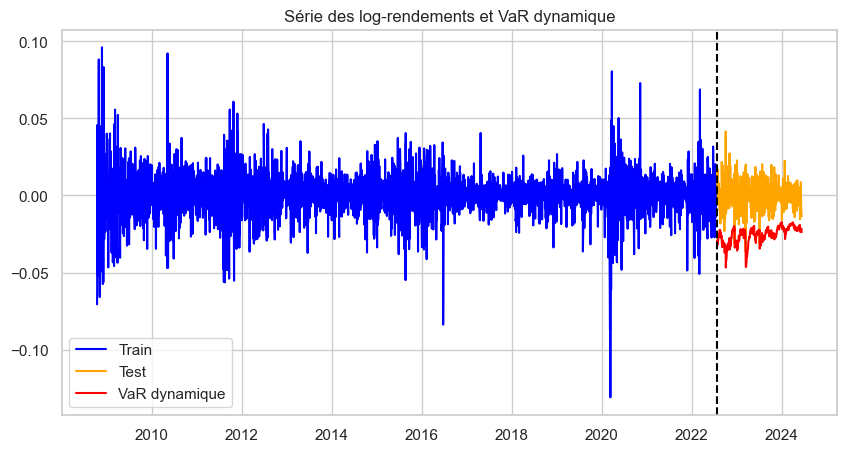

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(data_train, color="blue", label='Train')
plt.plot(data_test, color="orange", label='Test')
plt.plot(var_t, color="red",label='VaR dynamique')
plt.axvline(x=data_test.index[0], color='black', linestyle='--')
plt.legend()
plt.title('Série des log-rendements et VaR dynamique')
plt.show()

Text(0.5, 1.0, 'Zoom sur la VaR dynamique')

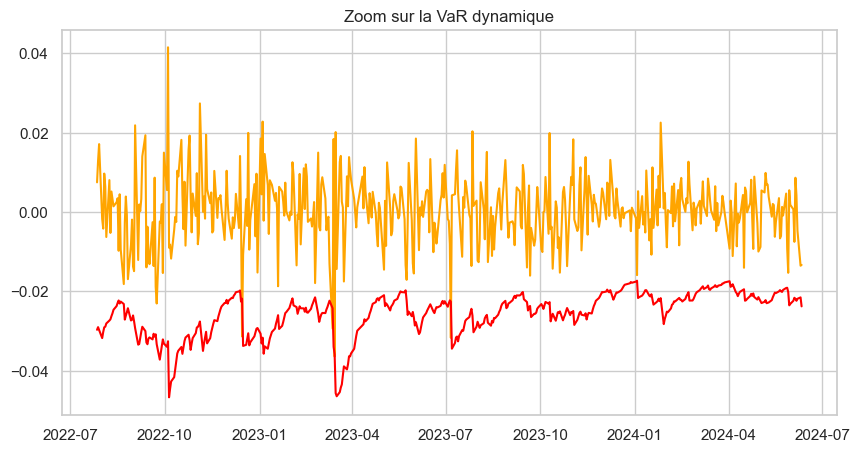

In [69]:
plt.figure(figsize=(10, 5))
plt.plot(data_test, color="orange")
plt.plot(var_t, color="red")
plt.title('Zoom sur la VaR dynamique')

##### Avec la méthode Block maxima

In [70]:
var_t = np.zeros(T_test)    # Composante moyenne
nb_exp = 0
for t in range(T_test):
    var_t[t] = (mu_t[t+T_train] + np.sqrt(sigma2[t+T_train])*var_BM_train)
    nb_exp += (r[t+T_train] < var_t[t]).astype(int)
    
var_t = pd.Series(var_t, index=data_test.index)
print(f"Nombre d'exceptions = {nb_exp} sur {T_test} jours")

Nombre d'exceptions = 3 sur 480 jours


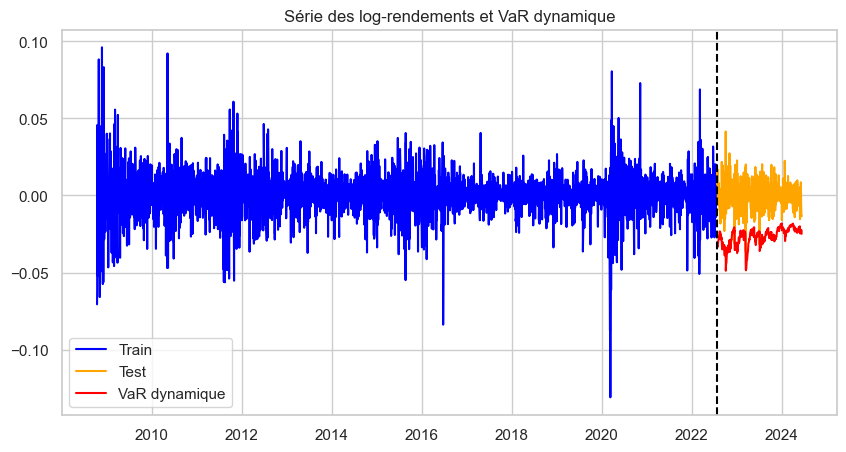

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(data_train, color="blue", label='Train')
plt.plot(data_test, color="orange", label='Test')
plt.plot(var_t, color="red",label='VaR dynamique')
plt.axvline(x=data_test.index[0], color='black', linestyle='--')
plt.legend()
plt.title('Série des log-rendements et VaR dynamique')
plt.show()

Text(0.5, 1.0, 'Zoom sur la VaR dynamique')

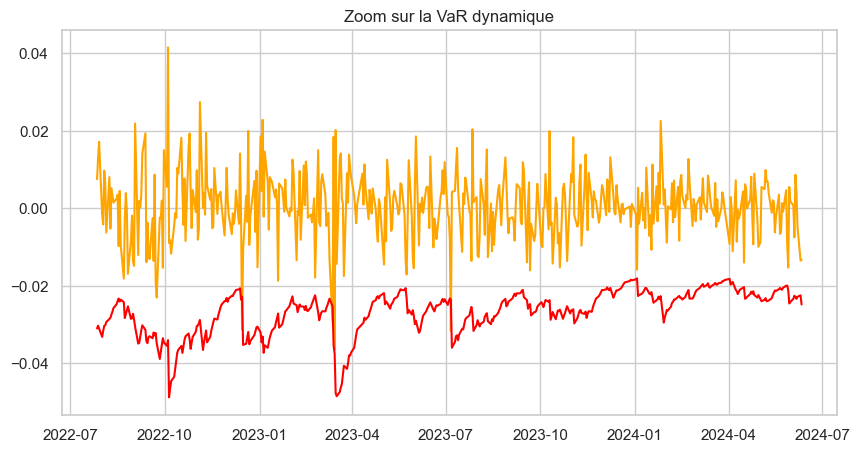

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(data_test, color="orange")
plt.plot(var_t, color="red")
plt.title('Zoom sur la VaR dynamique')

Avec la méthode BM ou historique, les VaR dynamiques calibrées sont à peu être identique. 
En effet, la méthode historique génère 4 exceptions tandis que la méthode BM génère 3 exceptions. Cela est du à l'estimation de la VaR selon ces duex méthodes sur les résidus studentisés.

# Conclusion

À travers ce travail pratique, nous avons exploré plusieurs approches d’estimation de la Value at Risk (VaR), chacune fondée sur des hypothèses et des méthodes statistiques spécifiques.

La première partie, consacrée aux méthodes classiques (historique, paramétrique gaussienne et studentienne), a mis en lumière leur simplicité d’implémentation, mais aussi leurs limites. En particulier, ces modèles peinent à représenter correctement les queues épaisses des distributions financières, ce qui peut conduire à une sous-estimation significative du risque en période de forte volatilité.

La deuxième partie a introduit les techniques issues de la théorie des valeurs extrêmes (EVT). En se concentrant sur le comportement des queues de distribution, ces méthodes permettent une estimation plus robuste des pertes rares mais sévères. L’approche Peaks-Over-Threshold (POT), notamment, s’est révélée bien adaptée aux données financières, bien que la pertinence des résultats dépende fortement du choix du seuil.

La troisième partie a été consacrée aux modèles GARCH, qui permettent de modéliser l’hétéroscédasticité conditionnelle des rendements. En capturant la dynamique temporelle de la volatilité, ces modèles rendent la VaR plus sensible aux conditions de marché. Lorsqu’ils sont combinés à des distributions non gaussiennes (comme Student ou GED), ils permettent d’améliorer la précision de l’estimation du risque.

En somme, chaque méthode a ses forces et ses faiblesses. Pour un gestionnaire de risque, il est essentiel de ne pas s’appuyer sur une approche unique, mais au contraire de combiner plusieurs méthodes, en tenant compte des caractéristiques du portefeuille, du contexte de marché et de l’horizon temporel visé. Ce parcours comparatif illustre l’importance de recourir à des modèles plus flexibles et spécialisés, notamment en période de stress financier, pour disposer d'une estimation plus fiable de la VaR.

Au-delà de la simple conformité réglementaire, la VaR demeure un outil central pour les investisseurs et les institutions financières, leur permettant d’identifier, de mesurer et de gérer leurs expositions au risque. Néanmoins, puisqu’elle repose sur une modélisation statistique, la VaR est exposée à ce que l’on appelle le risque de modèle.

Le risque de modèle correspond à la possibilité de prendre de mauvaises décisions en se fondant sur un modèle mal spécifié, mal paramétré ou nourri par des données inappropriées. Il peut engendrer des erreurs de prévision, des interprétations erronées ou des pertes financières significatives. D'où l’importance de bien comprendre les hypothèses, les limites et le domaine de validité de chaque modèle.

C’est précisément dans cette zone de fragilité que l’intervention humaine devient cruciale. Une gestion rigoureuse du risque modèle passe par un sanity check régulier des modèles, un backtesting systématique, et une confrontation à des modèles alternatifs — plus simples ou plus complexes — afin de mieux cerner leurs zones de validité et de comprendre les écarts de résultats.

Ainsi, la qualité de l’analyse repose autant sur la rigueur technique que sur le jugement critique de l’analyste. Une approche prudente, diversifiée et réévaluée régulièrement constitue la clé d’une gestion du risque robuste, adaptée à la complexité croissante des marchés financiers.

